# 1.0 - Data prep

### 1.1.0 - Company-level: Engineer features by company  

In this section, we will collect the following company-level features from the Crunchbase API:
  
  - `company_name`
  - `funding`
  - `jobs_created`
  - `age_years`
  - `founders`
  - `city`
  - `region`
  - `category`
  - `ipo`
  
Then we will collect patent data per company from the USPTO API to create the feature:

  - `patents`
  
Then we will validate data on job creation from the Cruncbase API with data scraped from Wikipedia to strengthen the feature:

  - `jobs_created`

Additionally, we will:

- Match companies to Metropolitans based on their HQ and office location(s)
- Address errors and outliers
- Visualize distributions
  
### 1.2.0 - Entrepreneur-level: Locate entrepreneurs and map to companies  

In this section, we will:  

- Identify entrepreneurs (an entrepreneur is signified by anyone present at the company before Series A funding)
- Assign company impact to entrepreneurs
- Identify `female` and `male` entrepreneurs
- Address errors and outliers
- Visualize distributions

### 1.3.0 - Metro-level: Consolidate Metros and engineer Metro-specific features

Once the data is aggregated by entrepreneur we will:  

- Aggregate and combine data by Metropolitan
- Add Metropolitan-specific features:  
  - `population`
  - `gdp_per_capita`
  - `latitude`
  - `longitude` 
- Calculate mean, median, and std per population per Metropolitan
- Save data

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import requests
import json
import datetime
import os
from time import time as now
import math
from bs4 import BeautifulSoup
import urllib
import gender_guesser.detector as gender
from fuzzywuzzy import fuzz

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
PROJ_ROOT = Path().resolve().parent
EXT_DIR = PROJ_ROOT / 'data' / 'external'
IRM_DIR = PROJ_ROOT / 'data' / 'interim'
PRC_DIR = PROJ_ROOT / 'data' / 'processed'
RAW_DIR = PROJ_ROOT / 'data' / 'raw'
MAP_DIR = PROJ_ROOT / 'data' / 'mappings'
CRB_DIR = RAW_DIR / 'crunchbase_data'

### Load data if it exists

In [3]:
try:
    company_df = pd.read_csv(IRM_DIR / 'data_interim_company_df.csv', index_col=0)
    have_data = True
    # Remove company 'Yellow'
    i = company_df.loc[company_df.region == 'Armed Forces Europe, Middle East, & Canada'].index
    company_df = company_df.drop(i).reset_index(drop=True)
    # Change '[]' in founders to null
    company_df['founders'] = company_df['founders'].replace('[]', np.nan)
except FileNotFoundError:
    have_data = False

# 1.1.0 - Company-level: Engineer features by company 

## 1.1.1 - Get company-level data from Crunchbase API

In [4]:
def get_company_info(row):
    API_KEY = "954cc377a04e86270d6b24d15adab8d3"
    API_ENDPOINT = "https://api.crunchbase.com/v3.1/"
    
    name = row['name']
    permalink = row['permalink']
    print(name)
        
    # Call API
    founders = []
    query = 'relationships=founders,headquarters,category,ipo,offices'
    url = API_ENDPOINT + permalink + f'?user_key={API_KEY}'
    r = requests.get(url) 
    try:
        parsed = json.loads(r.text)
    except ValueError:
        print('ERROR')
        print(url)
        print(r)
        return
    # If company exists
    try:
        # If no headquarters, look into offices
        if parsed['data']['relationships']['headquarters']['paging']['total_items'] == 0:
            # Get number of offices
            num_offices = parsed['data']['relationships']['offices']['paging']['total_items']
            # If no offices
            if num_offices == 0:
                print('--NO OFFICES--')
            # If more than one offices, check out what the offices are
            elif num_offices > 1:
                print('CHECK-------------------~~~~~~~~~~~~~')
                print(parsed['data']['relationships']['offices'])
            # If one office, get the city
            else:
                city = parsed['data']['relationships']['offices']['item']['properties']['city']
    # If company doesn't exist
    except TypeError:
        pass
    # If possible, check the city of the headquarters and grab that
    try:
        try:
            country = parsed['data']['relationships']['headquarters']['item']['properties']['country']
            # If country is not in the US, don't include it
            if country != 'United States':
                return
        except TypeError:
            return
    except KeyError:
        country = np.nan
    # Get the city of the headquarters if possible
    try:
        city = parsed['data']['relationships']['headquarters']['item']['properties']['city']
    except KeyError:
        city = np.nan
    # Get the region if possible
    try:
        region = parsed['data']['relationships']['headquarters']['item']['properties']['region']
    except KeyError:
        region = np.nan
    for i in parsed['data']['relationships']['founders']['items']:
        founders.append(i['properties']['first_name'] + ' ' + i['properties']['last_name'])
    # Get the employee count, funding, founding and closing dates, and categories
    employee_count = parsed['data']['properties']['num_employees_max']
    funding = parsed['data']['properties']['total_funding_usd']
    founded_on = parsed['data']['properties']['founded_on']
    closed_on = parsed['data']['properties']['closed_on']
    categories = [x['properties']['name'] for x in parsed['data']['relationships']['categories']['items']]
    
    # Check if company has had an IPO
    if parsed['data']['relationships']['ipo']['paging']['total_items'] == 1:
        ipo = 1
    else:
        ipo = 0
    
    # Calculate age in years
    try:
        components = founded_on.split('-')
        year, month, day = int(components[0]), int(components[1]), int(components[2])
        if closed_on is None:
            age = datetime.date.today() -  datetime.date(year, month, day)
            age = np.round(age.days/365, 4)
        else:
            c_components = closed_on.split('-')
            year2, month2, day2 = int(c_components[0]), int(c_components[1]), int(c_components[2])
            age = datetime.date(year2, month2, day2) -  datetime.date(year, month, day)
            age = np.round(age.days/365, 4)
    except AttributeError:
        age = np.nan
                
    return {
        'company_name': name,
        'permalink': permalink,
        'funding': funding,
        'jobs_created': employee_count,
        'age_years': age,
        'founding_date': founded_on,
        'closing_date': closed_on,
        'founders': founders,
        'city': city,
        'region': region,
        'category': categories,
        'ipo': ipo
    }

In [5]:
if have_data == False:
    company_data = pd.read_csv(CRB_DIR / 'organizations.csv')
    company_data.head(3)

In [6]:
if have_data == False:
    list_of_company_data = []
    check = [1000, 5000, 7500, 10000, 20000, 30000, 40000, 50000, 75000, 100000,
             125000, 150000, 175000, 200000, 225000, 250000, 300000, 400000,
             500000, 600000, 700000]

    t0 = now()
    for i in company_data.index:
        if i in check:
            print(f'---------------{i}/{company_data.shape[0]}---------------')
        list_of_company_data.append(get_company_info(company_data.iloc[i]))
    t_end = now() - t0

In [7]:
if have_data == False:
    print(f'took {t_end} seconds to collect company-level data.')

In [8]:
if have_data == False:
    list_of_company_data = [item for item in list_of_company_data if item is not None]

In [9]:
if have_data == False:
    company_df = pd.DataFrame(list_of_company_data, columns=[
        'company_name',
        'permalink',
        'founders',
        'funding',
        'jobs_created',
        'age_years',
        'founding_date',
        'closing_date',
        'category',
        'ipo',
        'city',
        'region'
    ])
    # Save raw company data
    company_df.to_csv(RAW_DIR / 'raw_company_df.csv')

In [10]:
if have_data == False:
    # Filter out venture capital
    vc_to_drop = []
    for i in company_df.index:
        if 'Venture Capital' in company_df.at[i, 'category']:
            vc_to_drop.append(i)

    # Drop venture capital
    company_df = company_df.drop(vc_to_drop).reset_index(drop=True)
    # View head
    company_df.head()

In [11]:
if have_data == False:
    # Filter out companies with no city listed
    company_df = company_df[company_df.city.notnull()]
    print(company_df.shape)
    # Save company data
    company_df.to_csv(IRM_DIR / 'company_df.csv')

### Exclude companies

In [12]:
# Companies we want to exclude (using permalinks because company name may not be unique)
companies_to_exclude = [
    '/organizations/bloom-6', # there is another Bloom, this one has NaNs
    '/organizations/sesepei-com', # have state but not city
    '/organizations/doublelinx', # have state but not city
    '/organizations/manufacturing-resources-international', # have state but not city
    '/organizations/small-business-innovation-research', # have state but not city
    '/organizations/shockatoo', # have state but not city
    '/organizations/proxiserve', # location doesn't exist
    '/organizations/arcade-heroes', # have state but not city
    '/organizations/inzumi', # city unclear
    '/organizations/savvis', # city unclear
    '/organizations/null-6874' # null name
]

## 1.1.2 - Get patent data from USPTO API

In [13]:
def get_patents(company_row):
    """
    Function that sends an API request to the
    USPTO API to get the number of patents for
    a particular company, returning the patent
    count.
    """
    patents = 0
    company = company_row['company_name']
    confidences = []
    # print(company)

    # Make a get request
    response = requests.get('http://www.patentsview.org/api/assignees/query?q=' +
                            '{"_begins":{"assignee_organization":"' + str(company) + '"}}' +
                            '&f=["assignee_organization","patent_number","app_date",' +
                            '"patent_date","location_city","location_state"]')

    # Jsonify response
    try:
        parsed = json.loads(response.content)
    except ValueError:
        print(company_row['company_name'], 'ERROR')
        return
    # How many assignees?
    try:
        count = parsed['count']
    except KeyError:
        return patents

    # If there's no patents
    if count == 0:
        return patents
    else:
        for assignee_pkg in parsed['assignees']:
            ########
            locations = assignee_pkg['locations']
            if len(locations) > 1:
                print('ALERT: Multiple locations')
                print(locations)

            # Get patent information
            patent_city = assignee_pkg['locations'][0]['location_city']
            patent_pkg = assignee_pkg['patents']
            # For each patent
            for p in patent_pkg:
                patent_date = p['patent_date']
                # Check validity of patent
                validity, confidence = check_validity(
                    company_city=company_row['city'],
                    founding_date=company_row['founding_date'],
                    closing_date=company_row['closing_date'],
                    patent_date=patent_date,
                    patent_city=patent_city
                )
                if validity:
                    patents += 1
                    confidences.append(confidence)

    if len(confidences) > 0:
        return patents, np.round(np.mean(confidences), 2)
    else:
        return patents, None

In [14]:
def check_validity(company_city, founding_date, closing_date,
                   patent_date, patent_city=None):
    """
    Function that checks whether a given patent
    application is within the dates of a company's
    life, and if the cities match (if the city of
    the patent application is provided).
    """
    # Convert strings to datetime type
    founding_date = datetime.datetime.strptime(founding_date, '%Y-%m-%d')
    patent_date = datetime.datetime.strptime(patent_date, '%Y-%m-%d')
    
    try:
        # If closing date is null, company is still running
        if math.isnan(closing_date):
            # Check founding date vs. patent(s)
            if patent_date < founding_date:
                return False, 0
            else:
                # Check city if it exists
                if patent_city:
                    if company_city == patent_city:
                        return True, 2
                    return False, 0
                return True, 1
    # If company has closed (TypeError occurs if closing_date is not NaN)
    except TypeError:
        closing_date = datetime.datetime.strptime(closing_date, '%Y-%m-%d') 
        # Check if patent app date is within dates of company's life
        if founding_date < patent_date < closing_date:
            # Check city if it exists
            if patent_city:
                if company_city == patent_city:
                    return True, 2
                else:
                    return False, 0
            else:
                return True, 1
        else:
            return False, 0

In [15]:
# Check 1
validity, confidend = check_validity(
    company_city='Hayward',
    founding_date='2000-01-01',
    closing_date='2009-09-09',
    patent_date='2002-02-02',
    patent_city='Hayward'
)
assert validity == True

In [16]:
# Check 2
validity, confidend = check_validity(
    company_city='Hayward',
    founding_date='2000-01-01',
    closing_date='2009-09-09',
    patent_date='2002-02-02',
    patent_city='Oakland'
)
assert validity == False

In [17]:
# Check 3
validity, confidend = check_validity(
    company_city='Hayward',
    founding_date='2000-01-01',
    closing_date=np.nan,
    patent_date='1999-02-02',
    patent_city='Hayward'
)
assert validity == False

### Collect data from API with above function

In [18]:
if have_data == False:
    # Collect patents
    checkpoints = [
        1000, 5000, 10000, 20000, 30000, 40000, 50000, 60000,
        70000, 80000, 90000, 100000, 110000, 120000, 130000,
        140000, 150000, 160000
    ]
    t0 = now()
    for i in company_df.index:
        if i in checkpoints:
            print('-----------------------------------------------------')
            print('Checkpoint: {}/{}'.format(i, company_df.shape[0]))
            print('-----------------------------------------------------')
        # If company name is not null
        try:
            patents, confidence = get_patents(company_df.iloc[i])
            if patents > 0:
                company = company_df.at[i, 'company_name']
                print(
                    f'{company}' + '.'*(36-len(company)) + '{:,} patent(s) total, c={}'.format(
                        patents,
                        confidence
                    ))
            company_df.at[i, 'patents'] = patents
            company_df.at[i, 'patent_confidence'] = confidence
        except TypeError:
            companies_to_exclude.append(company_df.iloc[i]['permalink'])
    t_patents = now() - t0

In [19]:
if have_data == False:
    print(f'Took {int(np.round(t_patents))} seconds to collect patents for all companies.')

In [20]:
if have_data == True:
    # Load mappings
    with open(MAP_DIR / 'PATENT_MAPPING.json') as json_file:
        PATENT_MAPPING = json.load(json_file)
    with open(MAP_DIR / 'PATENT_CONF_MAPPING.json') as json_file:
        PATENT_CONF_MAPPING = json.load(json_file)
    
    # Apply mappings
    company_df['patents'] = company_df['permalink'].map(PATENT_MAPPING).fillna(0).astype(int)
    company_df['patent_confidence'] = company_df['permalink'].map(PATENT_CONF_MAPPING)

### Check validity of results for all companies with more than 20 patents

In [21]:
def check_patents(company):
    """
    Function that sends an API request to the 
    USPTO API to get the number of patents for
    a particular company and the city, returning
    the patent info.
    """
    locations = []
    # Make a get request
    response = requests.get('http://www.patentsview.org/api/assignees/query?q=' +
                            '{"_begins":{"assignee_organization":"' + str(company) + '"}}' +
                            '&f=["assignee_organization","patent_number","app_date",' +
                            '"patent_date","location_city","location_state"]')

    # Jsonify response
    try:
        parsed = json.loads(response.content)
    except ValueError:
        print(company_row['company_name'], 'ERROR')
        return
    # How many assignees?
    try:
        count = parsed['count']
    except KeyError:
        return patents

    # If there's no patents
    if count == 0:
        return patents
    else:
        for assignee_pkg in parsed['assignees']:
            num_patents = len(assignee_pkg['patents'])
            locations = assignee_pkg['locations']
            patent_city = assignee_pkg['locations'][0]['location_city']
            patent_state = assignee_pkg['locations'][0]['location_state']
            
            print(assignee_pkg['assignee_organization'],
                  f'({num_patents})',
                  '- ' + str(patent_city) + ',',
                  patent_state
                 )
    
    return parsed

In [22]:
def check_patents(company):
    """
    Function that sends an API request to the 
    USPTO API to get the number of patents for
    a particular company, returning the patent
    info.
    """
    # Make a get request
    response = requests.get('http://www.patentsview.org/api/assignees/query?q=' + 
                            '{"_begins":{"assignee_organization":"' + str(company) + '"}}' +
                            '&f=["assignee_organization","patent_number","app_date",' +
                            '"patent_date","location_city","location_state"]')
    
    # Jsonify response
    parsed = json.loads(response.content)
    
    # Print assignees
    for x in parsed['assignees']:
        num_patents = len(x['patents'])
        print(x['assignee_organization'], f'({num_patents})')
    
    return parsed

In [23]:
def correct_patents(company, correct_num_patents):
    """
    Corrects the number of patents for a particular company
    """
    i = company_df.loc[company_df['company_name'] == company].index[0]
    company_df.at[i, 'patents'] = correct_num_patents

In [24]:
# Check all companies with more than 20 patents and have names of len < 12
# (shorter names tend to match with lots of names while longer ones are more unique)
count = 0
for i in company_df.index:
    try:
        if (company_df.at[i, 'patents'] >= 30) & (len(company_df.at[i, 'company_name']) <= 12):
            print(i, company_df.at[i, 'company_name'], company_df.at[i, 'patents'])
            count += 1
    except TypeError:
        pass

56 Thermo King 436
266 Brasstech 110
358 HeartFlow 142
474 Tripwire 38
1132 HALO2CLOUD 37
1217 NuCurrent 30
1246 Aeris 41
1337 Acucela 32
1385 Tego 34
1425 MicroVision 259
1505 Sensory 36
1674 Ultratech 187
1706 Vudu 46
1783 Box 102
2344 Welch Allyn 694
2663 Tensorcom 36
2825 TherOx 52
3156 Hypertherm 186
3357 Salter Labs 42
3433 Xencor 120
3689 NanoLumens 49
3817 Lifetouch 36
4129 Amazon 9537
4160 Avon Product 357
4306 Sling Media 96
4600 AtriCure 89
4767 AFL 134
4814 Xicato 79
5347 Theranos 112
5443 ALC 44
5570 Samumed 72
6596 iRobot 525
6658 GI Dynamics 51
7305 IP Holdings 88
7458 Alcon 897
7497 NASDAQ 48
7568 E Ink 369
7888 Ophthonix 51
8388 CH2M Hill 50
8644 QLogic 355
9384 Hussmann 158
9782 AOL 56
10036 Cavium 372
10048 Crocs 142
10237 TerraPower 66
10406 Stryker 1218
11455 Pactiv 328
12010 Curis 118
12252 Ambarella 138
12284 RSA Security 44
12335 aTyr Pharma 76
12407 8x8 99
12833 Memjet 109
12874 Calphalon 85
13128 Invuity 55
13535 TangoMe 35
13753 Nomadix 55
14277 SustainX 41
1

120719 EchoStar 886
120847 Endgate 31
120912 Oceanit 43
121770 Atlas Spine 50
122065 Numenta 37
122111 Circadence 36
122269 Foro Energy 51
122369 GreatCall 33
123232 Semitool 382
123542 Ideal Power 52
123561 Spansion 1082
123618 Coriant 32
123709 Landauer 45
123723 Lantronix 37
123730 Ceramatec 250
123766 T-Mobile 609
124223 Valencell 49
124320 Drop 386
124390 Neustar 47
124403 POET 66
124757 Verathon 31
125250 Flexera 43
125592 Nantero 219
125611 Osteotech 89
125993 Oscor 43
126362 Navteq 123
126383 Vital Signs 57
126601 Intrexon 116
126813 Hello 53
126933 Arinc 48
127549 BellSouth 103
127593 SkyBell 81
127817 IMRA America 277
127900 AmberWave 87
129335 PCTEL 66
129424 DocuSign 32
129456 Lipton 149
129893 Enpirion 75
130116 Fuhu 36
130367 Tesla 385
130586 NexPlanar 33
130707 Insulet 30
131176 Tellme 38
131311 NBCUniversal 94
131372 Casabella 38
131676 Afero 46
132102 Plug Power 154
132805 Meridian 52
132852 Hardinge 78
133219 Seeo 47
133443 IdaTech 108
133487 Trilliant 38
133580 Sipix

In [25]:
count

684

In [27]:
parsed = check_patents('Aeris')

Aeristech Limited (2)
Aeris Therapeutics, Inc. (6)
Aeris.Net (4)
Aeristech Control Technologies Limited (1)
AERIS TECHNOLOGY LLC (2)
Aeris Communications, Inc. (32)
AERIS (2)
Aeris Soluciones de Control, S.L. (2)
aeris GmbH (7)
aeris CAPITAL Sustainable IP Ltd. (10)
Aeris Therapeutics, LLC (4)
Aerispatiale Societe Nationale Industrielle (1)
Aeris Communication, Inc. (1)


In [28]:
company_df[company_df.company_name == 'Aeris']

,company_name,permalink,founders,funding,jobs_created,age_years,founding_date,closing_date,category,ipo,city,region,patents,patent_confidence
1246,Aeris,/organizations/aeris,['Syed Zaeem Hosain'],0,500.0,27.4795,1992-01-01,NaN,"['Network Security', 'Telecommunications', 'In...",0,San Jose,California,41,1.9


## 1.1.3 - Validate `jobs_created` data by scraping Wikipedia

In [29]:
def get_employee_count(company, curr_jobs_created, verbose=False):
    """
    Function that scrapes the employee count,
    if it exists, from the specified company's
    Wikipedia page.
    """
    url = 'http://en.wikipedia.org/w/api.php?action=query&prop=revisions&' \
          f'rvprop=content&format=json&titles={company}&rvsection=0'
    req = requests.get(url)
    parsed = json.loads(req.text)

    data = []
    interim = []

    try:
        for x in str(parsed['query']['pages']).split('|'):
            if len(data) == 0:
                if 'num_employees' in x:
                    data.append(x)
            else:
                break
    except KeyError:
        return curr_jobs_created

    if len(data) == 0:
        return curr_jobs_created
    else:
        split_data = data[0].split(' ')
        for item in split_data:
            if any(char.isdigit() for char in item) == True:

                # If employee count is a range
                if ('-' in item) or ('–' in item):
                    if '-' in item:
                        first_num = item.split('-')[0]
                    elif '–' in item:
                        first_num = item.split('–')[0]
                    try:
                        second_num_raw = item.split('-')[1]
                    except IndexError:
                        second_num_raw = item.split('–')[1]
                    second_num_final = []
                    for c in second_num_raw:
                        if c.isdigit() == True:
                            second_num_final.append(c)
                    second_num = ''.join(second_num_final)
                    try:
                        output = int(np.round((int(first_num) + int(second_num)) / 2))
                    except ValueError:
                        output = first_num.replace(',', '')
                        try:
                            output = int(output.split('<')[0])
                        except ValueError:
                            try:
                                output = int(output.split('&')[0])
                            except ValueError:
                                output = int(output.split(r'\\'))
                    if verbose == True:
                        print(output, (10 - len(str(output))) * '.', company)
                    return output

                # If there is a year after the count
                elif '(' in item:
                    for c in item:
                        if c == '(':
                            break
                        else:
                            if c.isdigit() == True:
                                interim.append(c)
                    output = ''.join(interim)
                    if verbose == True:
                        print(output, (10 - len(str(output))) * '.', company)
                    return output

                else:
                    for c in item:
                        if c.isdigit() == True:
                            interim.append(c)
                    output = ''.join(interim)
                    if verbose == True:
                        print(output, (10 - len(str(output))) * '.', company)
                    return output

    return curr_jobs_created

In [30]:
if have_data == False:
    # Collect jobs_created
    checkpoints = [
        1000, 5000, 10000, 20000, 30000, 40000, 50000, 60000,
        70000, 80000, 90000, 100000, 110000, 120000, 130000,
        140000, 150000, 160000
    ]
    t0 = now()
    for i in company_df.index:
        if i in checkpoints:
            print('------------------------------------------------')
            print('Checkpoint: {}/{}'.format(i, company_df.shape[0]))
            print('------------------------------------------------')
        company = company_df.at[i, 'company_name']
        jobs = get_employee_count(company, company_df.at[i, 'jobs_created'], verbose=True)
        # If company is closed, Wiki marks it as 0 jobs; in this case we want the Crunchbase number
        if jobs != 0:
            company_df.at[i, 'jobs_created'] = jobs
    t_jobs = now() - t0

In [31]:
if have_data == False:
    print(f'Took {int(np.round(t_jobs))} seconds to collect job data from Wikipedia on {company_df.shape[0]} companies.')

## 1.1.4 - Match companies to Metropolitans

### Correct errors in location (`city` or `region`/state)

In [32]:
# Wannabiz
i = company_df.loc[company_df.permalink == '/organizations/wannabiz-3'].index[0]
company_df.at[i, 'region'] = 'New York'

In [33]:
# Mckees Rocks
subset = company_df.loc[company_df.city == 'Mckees Rocks']
i = subset.loc[subset.region == 'Pennsylvania'].index
for each in i:
    company_df.at[i, 'city'] = 'McKees Rocks'

In [34]:
# Shawnee Mission
subset = company_df.loc[company_df.city == 'Shawnee Mission']
i = subset.loc[subset.region == 'Kansas'].index
for each in i:
    company_df.at[i, 'city'] = 'Shawnee'

In [35]:
# Foothill Ranch, CA is now in Lake Forest, CA
subset = company_df.loc[company_df.city == 'Foothill Ranch']
i = subset.loc[subset.region == 'California'].index
for each in i:
    company_df.at[i, 'city'] = 'Lake Forest'

In [36]:
# Chatham, NJ
subset = company_df.loc[company_df.city == 'Chatham']
i = subset.loc[subset.region == 'New Jersey'].index
for each in i:
    company_df.at[i, 'city'] = 'Morristown'

In [37]:
# Washington, KY
subset = company_df.loc[company_df.city == 'Washington']
i = subset.loc[subset.region == 'Kentucky'].index
for each in i:
    company_df.at[i, 'city'] = 'Maysville'

In [38]:
# Hermitage, TN
subset = company_df.loc[company_df.city == 'Hermitage']
i = subset.loc[subset.region == 'Tennessee'].index
for each in i:
    company_df.at[i, 'city'] = 'Nashville'

In [39]:
# Fort Monmouth, NJ
subset = company_df.loc[company_df.city == 'Fort Monmouth']
i = subset.loc[subset.region == 'New Jersey'].index
for each in i:
    company_df.at[i, 'city'] = 'Middletown Township'

In [40]:
# Riverside, RI
subset = company_df.loc[company_df.city == 'Riverside']
i = subset.loc[subset.region == 'Rhode Island'].index
for each in i:
    company_df.at[i, 'city'] = 'East Providence'

In [41]:
# Saint Louis, MO
subset = company_df.loc[company_df.city == 'Saint Louis']
i = subset.loc[subset.region == 'Missouri'].index
for each in i:
    company_df.at[i, 'city'] = 'St Louis'

### Create mapping of states to abbreviations

In [42]:
STATE_MAPPING = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [43]:
# Save mapping
with open(MAP_DIR / 'STATE_MAPPING.json', 'w') as f:
    json.dump(STATE_MAPPING, f, sort_keys=True, indent=4)

In [44]:
def get_city_and_state(row):
    return row['city'] + ', ' + STATE_MAPPING[row['region']]

In [45]:
company_df['city_and_state'] = company_df.apply(lambda row: get_city_and_state(row), axis=1)

### Scrape mapping data from Wikipedia

Each city should have its own page on Wikipedia in which the county is listed. Each state has its own Wikipedia page which lists all Metro levels, including counties, within that state. These pages used together can create a mapping of city (and state) to county, and county to Metropolitan. This should encompass all cities (that have Wiki pages) and will reduce manual entries substantially.

#### City to County

In [46]:
county_check_list = []

In [47]:
def get_county(row):
    """
    Given a row of company data, collect the county
    from the city's Wikipedia page if it's not already
    in the mapping.
    """
    city = row['city']
    state = row['region']
    city_and_state = row['city_and_state']
        
    if city_and_state not in CITY_COUNTY_MAPPING.keys():
        url = f'https://en.wikipedia.org/wiki/{city},_{state}'

        if ' ' in state:
            state = state.replace(' ', '_')

        request = urllib.request.Request(url)
        try:
            response = urllib.request.urlopen(request)
        # If there's an error, try replacing the space with a dash
        except urllib.error.HTTPError as e:
            try:
                new_city = city.replace(' ', '-')
                url = f'https://en.wikipedia.org/wiki/{new_city},_{state}'
                request = urllib.request.Request(url)
                response = urllib.request.urlopen(request)
            # If there's an error, try replacing the space with an underscore
            except urllib.error.HTTPError as e:
                try:
                    new_city = city.replace(' ', '_')
                    url = f'https://en.wikipedia.org/wiki/{new_city},_{state}'
                    request = urllib.request.Request(url)
                    response = urllib.request.urlopen(request)
                # If there's an error, try removing the space
                except urllib.error.HTTPError as e:
                    try:
                        new_city = city.replace(' ', '')
                        url = f'https://en.wikipedia.org/wiki/{new_city},_{state}'
                        request = urllib.request.Request(url)
                        response = urllib.request.urlopen(request)
                    # If there's still an error, add company to check list
                    except urllib.error.HTTPError as e:
                        county_check_list.append({company_df.at[i, 'company_name']: city_and_state})
                        return

        dfs = pd.read_html(url)
        for df in dfs:
            if len(df) > 5:
                break

        cols = df.columns
        if 'County/Borough' in df[cols[0]].values:
            county = df.loc[df[cols[0]] == 'County/Borough'][cols[1]].values[0]
        elif 'County' in df[cols[0]].values:
            county = df.loc[df[cols[0]] == 'County'][cols[1]].values[0]
        elif 'Counties' in df[cols[0]].values:
            counties = df.loc[df[cols[0]] == 'Counties'][cols[1]].values[0]
            county = counties.split(',')[0]
        elif 'Parish' in df[cols[0]].values:
            county = df.loc[df[cols[0]] == 'Parish'][cols[1]].values[0]
        else:
            county = 'none'
            
        county = county.replace('.', '')
        if '(' in county:
            county = county.split(' (')[0]
        if '[' in  county:
            county = county.split('[')[0]
        if ',' in county:
            county = county.split(',')[0]
        if 'and' in county:
            county = county.split(' and')[0]
        if ' County' in county:
            county = county.replace(' County', '')

        CITY_COUNTY_MAPPING[city_and_state] = county
    
        return county
    return CITY_COUNTY_MAPPING[city_and_state]

In [48]:
# Check if mapping exists in directory
if os.path.isfile(MAP_DIR / 'CITY_COUNTY_MAPPING.json'):
    # Load mapping if it exists
    with open(MAP_DIR / 'CITY_COUNTY_MAPPING.json') as json_file:
        CITY_COUNTY_MAPPING = json.load(json_file)
# If they doesn't exist, make them
else:
    CITY_COUNTY_MAPPING = {}
    for i in company_df.index:
        county = get_county(company_df.iloc[i])

        city = company_df.at[i, 'city']
        print(i, city, '---', county)
    
    # Address special cases (the city is also the county, or independent city)
    CITY_COUNTY_MAPPING['San Francisco, CA'] = 'San Francisco'
    CITY_COUNTY_MAPPING['New York, NY'] = 'New York'
    CITY_COUNTY_MAPPING['Denver, CO'] = 'Denver'
    CITY_COUNTY_MAPPING['Anchorage, AK'] = 'Municipality of Anchorage'
    CITY_COUNTY_MAPPING['Washington, DC'] = 'District of Columbia'
    CITY_COUNTY_MAPPING['St Louis, MO'] = 'St Louis'
    CITY_COUNTY_MAPPING['Baltimore, MD'] = 'Baltimore (Independent city)'
    CITY_COUNTY_MAPPING['Arlington, VA'] = 'Arlington'
    CITY_COUNTY_MAPPING['Richmond, VA'] = 'Richmond'
    CITY_COUNTY_MAPPING['Alexandria, VA'] = 'Alexandria'
    CITY_COUNTY_MAPPING['Colorado Springs, CO'] = 'Colorado Springs'
    CITY_COUNTY_MAPPING['Fairfax, VA'] = 'Fairfax'
    CITY_COUNTY_MAPPING['Charlottesville, VA'] = 'Charlottesville'
    CITY_COUNTY_MAPPING['Virginia Beach, VA'] = 'Virginia Beach'
    CITY_COUNTY_MAPPING['Carson City, NV'] = 'Carson City, NV'
    CITY_COUNTY_MAPPING['Norfolk, VA'] = 'Norfolk'

    # Multiple counties were concatenated
    CITY_COUNTY_MAPPING['Portland, OR'] = 'Multnomah'
    CITY_COUNTY_MAPPING['Richardson, TX'] = 'Dallas'

    # Other
    CITY_COUNTY_MAPPING['Sherman Oaks, CA'] = 'Los Angeles'
    CITY_COUNTY_MAPPING['Littleton, CO'] = 'Arapahoe'
    CITY_COUNTY_MAPPING['Broomfield, CO'] = 'Broomfield'
    CITY_COUNTY_MAPPING['Longmont, CO'] = 'Boulder'
    CITY_COUNTY_MAPPING['Louisville, CO'] = 'Boulder'
    CITY_COUNTY_MAPPING['Westminster, CO'] = 'Adams'
    CITY_COUNTY_MAPPING['Golden, CO'] = 'Jefferson'
    CITY_COUNTY_MAPPING['Falls Church, VA'] = 'Falls Church'
    CITY_COUNTY_MAPPING['The Woodlands, TX'] = 'Montgomery'

In [49]:
# Save mapping if it was just created
if not os.path.isfile(MAP_DIR / 'CITY_COUNTY_MAPPING.json'):
    with open(MAP_DIR / 'CITY_COUNTY_MAPPING.json', 'w') as f:
        json.dump(CITY_COUNTY_MAPPING, f, sort_keys=True, indent=4)

In [50]:
# Create county column
company_df['county'] = company_df['city_and_state'].replace(CITY_COUNTY_MAPPING)

#### County to Metro

In [51]:
def get_metro_from_county(state):
    STAT_AREA_POPULATION_MAPPING = {}
    COUNTY_METRO_MAPPING = {}
    MSA_CSA_MAPPING = {}
    url = f'https://en.wikipedia.org/wiki/{state}_statistical_areas'
    # New Hampshire is a special case
    if state == 'New Hampshire':
        r = requests.get(url)
        website = r.text
        df = pd.read_html(website)[0]
    # Montana, Vermont, Alaska, Hawaii are special cases
    elif state in [
        'Montana',
        'Vermont',
        'Alaska',
        'Hawaii',
        'Wyoming'
    ]:
        df = pd.read_html(f'https://en.wikipedia.org/wiki/{state}_statistical_areas')[0]
        if state == 'Wyoming':
            df = df.iloc[:, :4]
        # Add two columns of 'none' at the beginning so it matches the shape of the other states
        df = pd.concat([
            pd.DataFrame(
                {
                    'CSA': ['none']*df.shape[0],
                    'Population': ['none']*df.shape[0]
                }
            ),
            df
        ], axis=1)
        # Remove common error if present
        if 'of' in df.iloc[-1][2]:
            df.drop(df.tail(1).index, inplace=True)
    # For regular cases
    else:
        # Scrape table from Wikipedia
        dfs = pd.read_html(url)
        if len(dfs[0]) < 5:
            df = dfs[1]
        else:
            df = dfs[0]
        # Remove common error if present
        if 'of' in df.iloc[-1][0]:
            df = df.drop(df.tail(1).index).reset_index(drop=True)
            
    # Get rid of extraneous columns
    if df.shape[1] > 6:
        df = df.iloc[:, :6]
    # Drop nulls
    df = df.dropna().reset_index(drop=True)

    # Get statistical levels
    for i in df.index:
        county = df.iat[i, 4]
        # Format county name
        if 'City and County of' in county:
            county = county.split('of ')[1]
        elif ('County,' in county) or ('County' in county):
            county = county.split(' County')[0]
        elif 'Census Area' in county:
            county = county.split(' Census Area')[0]
        elif ',' in county:
            county = county.split(',')[0]
        county = county.replace('City of ', '')
        county = county.replace(' City', '')     
        county = county.replace(' Parish', '')
        csa = df.iat[i, 0].replace('.', '')
        cbsa = df.iat[i, 2].replace('.', '')
        population = str(df.iat[i, 3])
        # Check if population is pop from 2 years combined
        if len(population) >= 9:
            # Get the first half of the string
            population = population[:math.ceil(len(population)/2)]
        # Format cbsa
        for phrase in [
            'Metropolitan Statistical Area',
            'MSA',
            'Micropolitan Statistical Area',
            'μSA',
            'County'
        ]:
            if phrase in cbsa:
                cbsa = cbsa.replace(f' {phrase}', '')
        COUNTY_METRO_MAPPING[county.replace('.', '')] = cbsa
        STAT_AREA_POPULATION_MAPPING[cbsa] = population.replace(',', '')
        MSA_CSA_MAPPING[cbsa] = csa

    return STAT_AREA_POPULATION_MAPPING, COUNTY_METRO_MAPPING, MSA_CSA_MAPPING

In [52]:
# Check if mapping exists in directory
if os.path.isfile(MAP_DIR / 'STATE_COUNTY_METRO_MAPPING.json'):
    with open(MAP_DIR / 'STATE_COUNTY_METRO_MAPPING.json') as json_file:
        STATE_COUNTY_METRO_MAPPING = json.load(json_file)
    with open(MAP_DIR / 'STATE_STAT_AREA_POPULATION_MAPPING.json') as json_file:
        STATE_STAT_AREA_POPULATION_MAPPING = json.load(json_file)
    with open(MAP_DIR / 'STATE_MSA_CSA_MAPPING.json') as json_file:
        STATE_MSA_CSA_MAPPING = json.load(json_file)

# If they don't exist, make them
else:
    STATE_STAT_AREA_POPULATION_MAPPING = {}
    STATE_COUNTY_METRO_MAPPING = {}
    STATE_MSA_CSA_MAPPING = {}
    for state in STATE_MAPPING.keys():
        try:
            STAT_AREA_POPULATION_MAPPING, COUNTY_METRO_MAPPING, MSA_CSA_MAPPING = get_metro_from_county(state)
            STATE_STAT_AREA_POPULATION_MAPPING[state] = STAT_AREA_POPULATION_MAPPING
            STATE_COUNTY_METRO_MAPPING[state] = COUNTY_METRO_MAPPING
            STATE_MSA_CSA_MAPPING[state] = MSA_CSA_MAPPING
        except TypeError:
            pass
    
    # Address special cases
    STATE_COUNTY_METRO_MAPPING['District of Columbia']['District of Columbia'] = 'Washington-Arlington-Alexandria, DC-VA-MD-WV'
    STATE_COUNTY_METRO_MAPPING['Maryland']['Baltimore (Independent city)'] = 'Baltimore, MD'
    STATE_STAT_AREA_POPULATION_MAPPING['Maryland']['Baltimore, MD'] = '602495'
    STATE_COUNTY_METRO_MAPPING['Virginia']['Richmond'] = 'Richmond, VA'
    STATE_COUNTY_METRO_MAPPING['Colorado']['Colorado Springs'] = 'Colorado Springs, CO'
    STATE_COUNTY_METRO_MAPPING['Nevada']['Carson City, NV'] = 'Carson City, NV'
    del STATE_COUNTY_METRO_MAPPING['Nevada']['Carson']
    for each in STATE_COUNTY_METRO_MAPPING['Washington']:
        if STATE_COUNTY_METRO_MAPPING['Washington'][each] == 'Portland-Vancouver-Beaverton, OR-WA':
            STATE_COUNTY_METRO_MAPPING['Washington'][each] = 'Portland-Vancouver-Hillsboro, OR-WA'
    for each in STATE_COUNTY_METRO_MAPPING['Massachusetts']:
        if STATE_COUNTY_METRO_MAPPING['Massachusetts'][each] == 'Boston-Cambridge-Quincy, MA-NH':
            STATE_COUNTY_METRO_MAPPING['Massachusetts'][each] = 'Boston-Cambridge-Newton, MA-NH'
    for each in STATE_COUNTY_METRO_MAPPING['South Carolina']:
        if STATE_COUNTY_METRO_MAPPING['South Carolina'][each] == 'Charlotte-Gastonia-Concord, NC-SC':
            STATE_COUNTY_METRO_MAPPING['South Carolina'][each] = 'Charlotte-Concord-Gastonia, NC-SC'
    for each in STATE_COUNTY_METRO_MAPPING['Kentucky']:
        if STATE_COUNTY_METRO_MAPPING['Kentucky'][each] == 'Cincinnati-Middletown, OH-KY-IN':
            STATE_COUNTY_METRO_MAPPING['Kentucky'][each] = 'Cincinnati, OH-KY-IN'
    for each in STATE_COUNTY_METRO_MAPPING['Indiana']:
        if STATE_COUNTY_METRO_MAPPING['Indiana'][each] == 'Cincinnati-Middletown, OH-KY-IN':
            STATE_COUNTY_METRO_MAPPING['Indiana'][each] = 'Cincinnati, OH-KY-IN'

In [53]:
# Save mappings if just created
if not os.path.isfile(IRM_DIR / 'STATE_COUNTY_METRO_MAPPING.json'):
    with open(MAP_DIR / 'STATE_STAT_AREA_POPULATION_MAPPING.json', 'w') as f:
        json.dump(STATE_STAT_AREA_POPULATION_MAPPING, f, sort_keys=True, indent=4)
    with open(MAP_DIR / 'STATE_COUNTY_METRO_MAPPING.json', 'w') as f:
        json.dump(STATE_COUNTY_METRO_MAPPING, f, sort_keys=True, indent=4)
    with open(MAP_DIR / 'STATE_MSA_CSA_MAPPING.json', 'w') as f:
        json.dump(STATE_MSA_CSA_MAPPING, f, sort_keys=True, indent=4)

In [54]:
# Create Metro column
metro_error_count = 0
for i in company_df.index:
    CUR_STATE_COUNTY_METRO_MAPPING = STATE_COUNTY_METRO_MAPPING[company_df.at[i, 'region']]
    try:
        company_df.at[i, 'metro'] = CUR_STATE_COUNTY_METRO_MAPPING[company_df.at[i, 'county']]
    except KeyError:
        print(company_df.at[i, 'city_and_state'], '---', company_df.at[i, 'county'])
        metro_error_count += 1

Kenansville, FL --- none
Harrisonburg, VA --- None
Valdez, AK --- none
Telluride, CO --- none
Lynchburg, VA --- none
Fairbanks, AK --- none
Monroe Township, NJ --- none
Manassas, VA --- None
Texas, SC --- Texas, SC
Newtown, PA --- none
St. Charles, MO --- Saint Charles
Jersey, AR --- none
Candler, NC --- none
Loveland, CO --- none
Moffett Field, CA --- none
Zephyr Cove, NV --- none
Sun Valley, CA --- none
Moffett Field, CA --- none
Lafayette, CO --- none
North Billerica, MA --- none
Freehold, NJ --- none
Maryland, LA --- Maryland, LA
Pine Brook, NJ --- none
Vail, CO --- none
Ridgewood, NY --- none
Hyannis Port, MA --- none
Fairfield, NJ --- none
Steamboat Springs, CO --- none
Netherlands, MO --- none
Roslyn, NY --- none
Fountain, CO --- none
Lake, MI --- none
North Billerica, MA --- none
Fredericksburg, VA --- None
Georgia, LA --- Georgia, LA
Northridge, CA --- none
America, AL --- America, AL
Nassau, NY --- none
Manassas, VA --- None
Florence, MA --- none
Freehold, NJ --- none
Parker,

Duluth, MN --- Saint Louis
Roslyn, NY --- none
Union, NJ --- none
Newtown, PA --- none
Century City, CA --- none
Grapevine, TX --- Tarrant  Dallas Denton
Century City, CA --- none
Fairfield, NJ --- none
Freehold, NJ --- none
Northridge, CA --- none
Hot Springs Village, AR --- GarlandSaline
Northridge, CA --- none
Shreveport, LA --- none
Franklin, WI --- none
Texas, SC --- Texas, SC
West Mclean, VA --- West Mclean, VA
Waynesboro, VA --- none
Towanda, PA --- Bradford
Pueblo, CO --- none
West Hatfield, MA --- none
Guilford, NC --- Guilford, NC
Lewis Center, OH --- none
Granada Hills, CA --- none
Netherlands, MO --- none
Parker, CO --- Douglas 
Rye Beach, NH --- none
Roanoke, VA --- None
Rancho Dominguez, CA --- none
Woodland Park, CO --- none
Locust Grove, VA --- none
Barhamsville, VA --- none
Valley Stream, NY --- Nassau Village within Hempstead
Ridgewood, NY --- none
Fredericksburg, VA --- None
Texas, SC --- Texas, SC
Cedar Valley, UT --- none
Loveland, CO --- none
La, CA --- La, CA
Jac

Southern Md Facility, MD --- Southern Md Facility, MD
Hampton, VA --- None
La Salle, CO --- none
Warrington, PA --- none
Dayville, CT --- none
Roslyn, NY --- none
Arlington, TN --- Shelby Rachel Burrow Museum
Fredericksburg, VA --- None
Rincon, NM --- Dona Ana
India, PA --- India, PA
Grapevine, TX --- Tarrant  Dallas Denton
Newport News, VA --- none
Ft Myer, VA --- none
Florida, NY --- none
Needham Heights, MA --- Needham Heights, MA
Firestone, CO --- none
Fairview, NJ --- none
Meadowbrook, WV --- none
Sylmar, CA --- none
Fairfield, NJ --- none
Grapevine, TX --- Tarrant  Dallas Denton
Cedar Valley, UT --- none
Utah, TN --- Utah, TN
Incline Village, NV --- none
Glenwood Springs, CO --- Garfield Seat
Florida, NY --- none
Mclouth, KS --- Mclouth, KS
Jekyll Island, GA --- none
Big Prairie, OH --- none
Southwest Brevard Cnty, FL --- Southwest Brevard Cnty, FL
Parker, CO --- Douglas 
Willowbrook, IL --- none
Incline Village, NV --- none
Mississippi State, MS --- none
Ossining, NY --- none
Cr

Texas, SC --- Texas, SC
Rochelle, VA --- none
River Grove, IL --- none
Hutchins, TX --- Dallas City Type: Rural
Canoga Park, CA --- none
Roanoke, VA --- None
Studio City, CA --- none
Roanoke, VA --- None
Benton, PA --- none
Studio City, CA --- none
Shreveport, LA --- none
Danville, VA --- None
Harrisonburg, VA --- None
Scott Air Force Base, IL --- none
Helena, MT --- Lewis
Valley Stream, NY --- Nassau Village within Hempstead
Parker, CO --- Douglas 
Mckeesport, PA --- Mckeesport, PA
Allison Park, PA --- Allegheny Armstrong Beaver Brooke Butler Fayette Hancock Indiana Jefferson Lawrence Washington Westmoreland
Germany, GA --- Germany, GA
America, AL --- America, AL
Creede, CO --- Mineral Seat
Northern Washington Co, ME --- Northern Washington Co, ME
Lake Saint Louis, MO --- Lake Saint Louis, MO
Juneau, AK --- none
Canoga Park, CA --- none
Sylmar, CA --- none
Spring Branch, TX --- none
Roanoke, VA --- None
Maryland, LA --- Maryland, LA
Shreveport, LA --- none
Ray Brook, NY --- none
Monro

Helena, MT --- Lewis
Sanborn, NY --- none
Freehold, NJ --- none
Reseda, CA --- none
Florida, NY --- none
Abington, PA --- none
Puunene, HI --- none
Piney Flats, TN --- none
Little Switzerland, NC --- none
Loveland, CO --- none
Union, NJ --- none
Grove, IL --- Grove, IL
White Horse Beach, MA --- none
Wakefield, RI --- none
Playa Vista, CA --- none
Clinton Township, MI --- none
Westcliffe, CO --- none
Milton, MA --- Suffolk until 1793Norfolk thereafter
Woodland Park, CO --- none
Texas, SC --- Texas, SC
Lake City, CO --- Hinsdale Seat
Salem, WI --- none
India, PA --- India, PA
Mccall, ID --- Mccall, ID
Big Lake, AK --- none
Valley Stream, NY --- Nassau Village within Hempstead
Amarillo, TX --- PotterRandall
Northridge, CA --- none
Waimea, HI --- none
Milton, MA --- Suffolk until 1793Norfolk thereafter
Helena, MT --- Lewis
Granada Hills, CA --- none
Clinton Township, MI --- none
Grapevine, TX --- Tarrant  Dallas Denton
Rancho Dominguez, CA --- none
Playa Vista, CA --- none
Helena, MT --- L

Sunnyside, NY --- none
Roanoke, VA --- None
Lincoln University, PA --- none
Williamsburg, VA --- none
Rancho Dominguez, CA --- none
Lawrence, NY --- none
Grapevine, TX --- Tarrant  Dallas Denton
Fairfield, NJ --- none
Belvedere Tiburon, CA --- Belvedere Tiburon, CA
Frederick, CO --- none
Jessup, MD --- Anne Arundel Howard
Rumford, RI --- none
Milford, IN --- none
University Center, MI --- none
Incline Village, NV --- none
Steamboat Springs, CO --- none
Manassas, VA --- None
Morrisville, PA --- none
Georgia, LA --- Georgia, LA
Texas, SC --- Texas, SC
Lamar, CO --- Prowers Seat
Roslyn, NY --- none
North Chelmsford, MA --- none
Moffett Field, CA --- none
Fairfield, NJ --- none
Northridge, CA --- none
Suffolk, VA --- None
Fairfield, NJ --- none
Union, NJ --- none
Incline Village, NV --- none
Florida, NY --- none
Northridge, CA --- none
Hutchins, TX --- Dallas City Type: Rural
Suffolk, VA --- None
Newtown, PA --- none
Edgewater, FL --- none
Mcclellan, CA --- Mcclellan, CA
Watertown, CT --- 

Florida, NY --- none
Plymouth Meeting, MA --- Plymouth Meeting, MA
Roanoke, VA --- None
Woodbury, NY --- none
Florida, NY --- none
Florida, NY --- none
West Park, NY --- none
Chesapeake, VA --- None
Williamsville, VA --- none
Helena, MT --- Lewis
Duluth, MN --- Saint Louis
Canoga Park, CA --- none
Playa Vista, CA --- none
Pueblo, CO --- none
Neptune, NJ --- none
Charlestown, MA --- none
Germany, GA --- Germany, GA
Williamsburg, VA --- none
Belvedere Tiburon, CA --- Belvedere Tiburon, CA
Grapevine, TX --- Tarrant  Dallas Denton
Williamsburg, VA --- none
Grapevine, TX --- Tarrant  Dallas Denton
Fredericksburg, VA --- None
Oakwood, OH --- none
Neptune, NJ --- none
Fairfield, NJ --- none
Newtown, PA --- none
Studio City, CA --- none
Swanton, VT --- none
Cranberry Twp, PA --- Cranberry Twp, PA
West Chester, OH --- none
Union, NJ --- none
Brooklyn, MD --- none
Florida, NY --- none
Studio City, CA --- none
Pueblo, CO --- none
Helena, MT --- Lewis
University Park, PA --- none
West Columbia, SC

Lawrence, NY --- none
Washington Mills, NY --- none
Monroe, NJ --- none
Fairfield, NJ --- none
Johns Island, SC --- none
Texas, SC --- Texas, SC
Franklin, WI --- none
Brooklyn, CT --- none
Lynchburg, VA --- none
Florida, NY --- none
Shreveport, LA --- none
Kailua, HI --- none
Clinton Township, MI --- none
Newtown, PA --- none
Valley Stream, NY --- Nassau Village within Hempstead
Spicewood, TX --- none
West Chester, OH --- none
Century City, CA --- none
Netherlands, MO --- none
Newtown, PA --- none
Waynesboro, VA --- none
La, CA --- La, CA
Commerce City, CO --- none
Williamsburg, VA --- none
Studio City, CA --- none
Waterford, NY --- none
West Newton, MA --- none
Harrisonburg, VA --- None
St. Charles, MO --- Saint Charles
Bristol, CT --- none
North Chelmsford, MA --- none
Germany, GA --- Germany, GA
Manassas, VA --- None
Florida, NY --- none
Fairfield, NJ --- none
White Horse Beach, MA --- none
West Chester, OH --- none
Bath, OH --- none
Newport News, VA --- none
New Century, KS --- non

In [55]:
# Make unmatched Metros np.NaN instead of 'none'
company_df['metro'] = company_df['metro'].replace('none', np.nan)

In [56]:
# Take care of these later
company_df[company_df.metro.isnull()].city_and_state.value_counts()

Florida, NY                89
Netherlands, MO            51
Roanoke, VA                45
Texas, SC                  44
Manassas, VA               43
Canada, KY                 42
Fairfield, NJ              40
Loveland, CO               40
Finland, MN                39
Grapevine, TX              39
Studio City, CA            38
Germany, GA                35
Newtown, PA                35
Lafayette, CO              35
Fredericksburg, VA         34
Shreveport, LA             33
Miramar Beach, FL          33
Incline Village, NV        32
Freehold, NJ               30
Spain, GA                  29
Arvada, CO                 29
West Chester, OH           29
St. Charles, MO            28
Playa Vista, CA            27
Northridge, CA             26
Hampton, VA                26
Canoga Park, CA            26
Aspen, CO                  25
Wa Keeney, KS              25
Parker, CO                 25
                           ..
Nevada, MO                  1
Dilley, TX                  1
Demopolis,

In [57]:
percent_null = np.round((company_df.shape[0]-company_df.metro.isna().sum())/company_df.shape[0]*100)
print(f'We currently have Metros assigned to {percent_null}% of companies')

We currently have Metros assigned to 97.0% of companies


## 1.1.5 - Address errors and outliers

### Exclude companies

In [58]:
# Eliminate repeats if there are any
companies_to_exclude = list(set(companies_to_exclude))

In [59]:
# View excluded companies
companies_to_exclude

['/organizations/bloom-6',
 '/organizations/null-6874',
 '/organizations/sesepei-com',
 '/organizations/small-business-innovation-research',
 '/organizations/manufacturing-resources-international',
 '/organizations/savvis',
 '/organizations/shockatoo',
 '/organizations/proxiserve',
 '/organizations/inzumi',
 '/organizations/arcade-heroes',
 '/organizations/doublelinx']

In [60]:
# Get indices we want to drop
indices_to_drop = company_df[company_df.permalink.isin(companies_to_exclude)].index

In [61]:
print(f'Dropping {len(indices_to_drop)} companies.')

Dropping 11 companies.


In [62]:
# Drop companies
company_df = company_df.drop(indices_to_drop).reset_index(drop=True)

In [63]:
company_df.shape

(164334, 17)

### Address null Metros

In [64]:
percent_null = np.round((company_df.shape[0]-company_df.metro.isna().sum())/company_df.shape[0]*100)
print(f'We currently have Metros assigned to {percent_null}% of companies')

We currently have Metros assigned to 97.0% of companies


In [65]:
print(f'{company_df.metro.isna().sum()} companies do not have assigned Metros.')

4240 companies do not have assigned Metros.


In [70]:
cities_unmatched = len(list(set(company_df[company_df.metro.isnull()]['city_and_state'])))
print(f'{cities_unmatched} cities are not matched to Metros.')

1402 cities are not matched to Metros.


In [71]:
# Drop companies without Metros
company_df = company_df[company_df.metro.notnull()].reset_index(drop=True)

### Address non-funded companies

In [72]:
# Exclude companies without funding and without jobs created and patents
non_funded_to_drop = list(company_df[
    (company_df.funding == 0) &
    (company_df.patents == 0) &
    (company_df.jobs_created.isnull())]['permalink']
)

In [73]:
# Get indices we want to drop
indices_to_drop = company_df[company_df.permalink.isin(non_funded_to_drop)].index

In [74]:
print(f'Dropping {len(indices_to_drop)} companies.')

Dropping 34923 companies.


In [75]:
# Drop companies
company_df = company_df.drop(indices_to_drop).reset_index(drop=True)

In [76]:
company_df.shape

(125171, 17)

### Check for duplicates

In [77]:
# Check out duplicates
duplicates = company_df[company_df.duplicated(subset=[
    'company_name',
    'founding_date',
    'city_and_state'
], keep=False)].sort_values(by='company_name')
duplicates

,company_name,permalink,founders,funding,jobs_created,age_years,founding_date,closing_date,category,ipo,city,region,patents,patent_confidence,city_and_state,county,metro
64591,Abacus Group,/organizations/abacus-group-llc,"['Viktor Tadijanovic', 'Chris Grandi']",0,250.0,11.4685,2008-01-01,NaN,"['Financial Services', 'Communities', 'Informa...",0,New York,New York,0,NaN,"New York, NY",New York,"New York-Newark-Jersey City, NY-NJ-PA"
50897,Abacus Group,/organizations/abacus-group,NaN,0,50.0,11.4685,2008-01-01,NaN,"['Recruiting', 'Finance']",0,New York,New York,0,NaN,"New York, NY",New York,"New York-Newark-Jersey City, NY-NJ-PA"
110113,All Children's Hospital,/organizations/all-childrens-hospital,NaN,0,500.0,93.5260,1926-01-01,NaN,"['Education', 'Health Care']",0,Saint Petersburg,Florida,0,NaN,"Saint Petersburg, FL",Pinellas,"Tampa-St Petersburg-Clearwater, FL"
25065,All Children's Hospital,/organizations/all-children-s-hospital,NaN,0,5000.0,93.5233,1926-01-01,NaN,"['Education', 'Health Care']",0,Saint Petersburg,Florida,0,NaN,"Saint Petersburg, FL",Pinellas,"Tampa-St Petersburg-Clearwater, FL"
15222,Beacon,/organizations/beacon-2,"['Reed Farnsworth', 'Ryan Morley', 'Wade Eyerl...",7500000,50.0,2.1644,2014-01-01,2016-03-01,"['Tourism', 'Travel', 'Leisure']",0,New York,New York,0,NaN,"New York, NY",New York,"New York-Newark-Jersey City, NY-NJ-PA"
40200,Beacon,/organizations/beacon,"['Mark Higgins', 'Kirat Singh']",18470000,NaN,5.4630,2014-01-01,NaN,"['Financial Services', 'Information Technology...",0,New York,New York,0,NaN,"New York, NY",New York,"New York-Newark-Jersey City, NY-NJ-PA"
72592,Bell Standard,/organizations/bell-standard-14c2,['Ronald Bell'],0,10.0,10.4685,2009-01-01,NaN,[],0,Los Angeles,California,0,NaN,"Los Angeles, CA",Los Angeles,"Los Angeles-Long Beach-Santa Ana, CA"
69692,Bell Standard,/organizations/bell-standard,['Ronald Bell'],0,10.0,10.4685,2009-01-01,NaN,"['Mobile Apps', 'Software']",0,Los Angeles,California,0,NaN,"Los Angeles, CA",Los Angeles,"Los Angeles-Long Beach-Santa Ana, CA"
85223,"Breast Cancer Car Donations Cleveland, OH",/organizations/breast-cancer-car-donations-cle...,NaN,0,50.0,NaN,NaN,NaN,[],0,Cleveland,Ohio,0,NaN,"Cleveland, OH",Cuyahoga,"Cleveland–Elyria, OH"
18420,"Breast Cancer Car Donations Cleveland, OH",/organizations/breast-cancer-car-donations-cle...,NaN,0,50.0,NaN,NaN,NaN,[],0,Cleveland,Ohio,0,NaN,"Cleveland, OH",Cuyahoga,"Cleveland–Elyria, OH"


In [78]:
# Remove duplicates
print(f'Dropping {len(duplicates)} duplicate rows.')
company_df = company_df.drop_duplicates(subset=['company_name', 'founding_date', 'city_and_state'])

Dropping 46 duplicate rows.


In [79]:
company_df.shape

(125144, 17)

In [80]:
# View nulls
company_df.isnull().sum()

company_name              0
permalink                 0
founders              73992
funding                   0
jobs_created           6795
age_years             14570
founding_date         14570
closing_date         122539
category                  0
ipo                       0
city                      0
region                    0
patents                   0
patent_confidence    114267
city_and_state            0
county                    0
metro                     0
dtype: int64

### Save processed company_df

In [81]:
company_df.to_csv(PRC_DIR / 'processed_company_df.csv')

### Load processed company_df

In [3]:
company_df = pd.read_csv(PRC_DIR / 'processed_company_df.csv', index_col=0)

## 1.1.6 - Visualize distributions

In [4]:
sns.set_style('darkgrid')

In [5]:
# For now, drop all nans in jobs_created
df = company_df[company_df.jobs_created.notnull()]

### `funding`

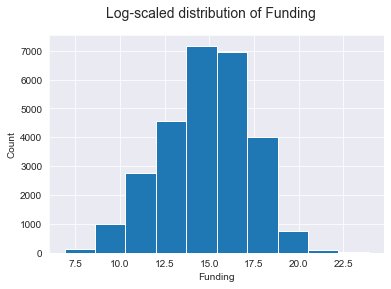

In [6]:
VAR = 'funding'
LABEL = 'Funding'
data = df[df[VAR] > 0]

np.log(data[VAR]).hist()

plt.suptitle(f'Log-scaled distribution of {LABEL}', fontsize=14)
plt.xlabel(LABEL)
plt.ylabel('Count');

### `jobs_created`

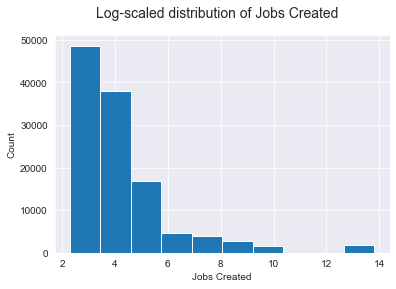

In [7]:
VAR = 'jobs_created'
LABEL = 'Jobs Created'
data = df[df[VAR] > 0]

np.log(data[VAR]).hist()

plt.suptitle(f'Log-scaled distribution of {LABEL}', fontsize=14)
plt.xlabel(LABEL)
plt.ylabel('Count');

### `patents`

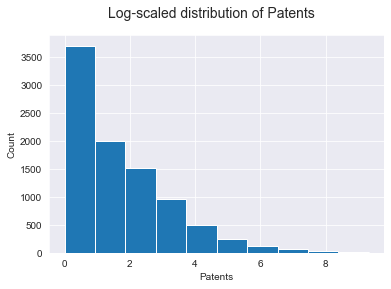

In [8]:
VAR = 'patents'
LABEL = 'Patents'
data = df[df[VAR] > 0]

np.log(data[VAR]).hist()

plt.suptitle(f'Log-scaled distribution of {LABEL}', fontsize=14)
plt.xlabel(LABEL)
plt.ylabel('Count');

# 1.2.0 - Entrepreneur-level: Locate entrepreneurs and map to companies 

## 1.2.1 - Identify entrepreneurs

An entrepreneur is anyone present at the company before Series A funding. This is likely the founding team of a company.

In [9]:
def get_additional_entrepreneurs(row):
    API_KEY = "954cc377a04e86270d6b24d15adab8d3"
    API_ENDPOINT = "https://api.crunchbase.com/v3.1"
    p = row['permalink']

    # Get date of first funding
    url = API_ENDPOINT + p + '/funding_rounds' + f'?user_key={API_KEY}'
    r = requests.get(url)
    #return json.loads(r.text)
    try:
        parsed = json.loads(r.text)
    except ValueError:
        return []
    try:
        num_funding_rounds = parsed['data']['paging']['total_items']
    except TypeError:
        return []
    if num_funding_rounds > 0:
        funding_rounds = parsed['data']['items']
        # Get earliest funding round, and type of funding
        dates = []
        for funding_round in funding_rounds:
            date = funding_round['properties']['announced_on']
            date = datetime.datetime.strptime(date, '%Y-%m-%d')
            dates.append(date.date())
        earliest_i = dates.index(min(dates))
        earliest_date = min(dates)
        funding_type = funding_rounds[earliest_i]['properties']['funding_type']
        series = funding_rounds[earliest_i]['properties']['series']
        #     print(earliest_date)
        #     print(funding_type)
        #     print(series)

        # Keep track of employees and dates
        employees = []

        # Get start dates for past employees
        url = API_ENDPOINT + p + '/past_team' + f'?user_key={API_KEY}'
        r = requests.get(url)
        parsed = json.loads(r.text)
        past_team = parsed['data']['items']
        for job in past_team:
            person = job['relationships']['person']['properties']
            first_name, last_name = person['first_name'], person['last_name']
            gender = person['gender']
            props = job['properties']
            title = props['title']
            started = props['started_on']
            ended = props['ended_on']
            employees.append(
                {
                    'name': first_name + ' ' + last_name,
                    'start': started,
                    'end': ended
                }
            )

        # Get start dates for current team
        url = API_ENDPOINT + p + '/current_team' + f'?user_key={API_KEY}'
        r = requests.get(url)
        parsed = json.loads(r.text)
        current_team = parsed['data']['items']
        for job in current_team:
            person = job['relationships']['person']['properties']
            first_name, last_name = person['first_name'], person['last_name']
            gender = person['gender']
            props = job['properties']
            title = props['title']
            started = props['started_on']
            ended = props['ended_on']
            employees.append(
                {
                    'name': first_name + ' ' + last_name,
                    'start': started,
                    'end': ended
                }
            )

        # Compare dates - go through all employees
        entrepreneurs = []
        for employee in employees:
            # Check start date against funding date
            start = employee['start']
            end = employee['end']
            if start:
                start = datetime.datetime.strptime(start, '%Y-%m-%d').date()
                if start < earliest_date:  # earliest_date is earliest funding date
                    # Check end date against funding date
                    if end:
                        end = datetime.datetime.strptime(end, '%Y-%m-%d').date()
                        if end > earliest_date:
                            entrepreneurs.append(employee['name'])
                    else:
                        entrepreneurs.append(employee['name'])

    #     print(employees)
    #     print()
    #     print(earliest_date)
    #     print()

    #         print(funding_type)
    #         print(series)
    #         print(list(set(entrepreneurs)))

    # If no funding rounds
    else:
        entrepreneurs = []

    return list(set(entrepreneurs))

In [10]:
#get_founding_entrepreneurs(company_df.iloc[47])

In [11]:
def string_to_list(string):
    """Takes in a string of a list and
    returns a list of the elements"""
    string = string.replace('[', '')
    string = string.replace(']', '')
    string = string.replace("'", '')
    elements = string.split(', ')
    elements = [e for e in elements if len(e) > 0]
    return elements

In [12]:
# If using founders as entrepreneurs
entrepreneurs_list = []
for i in company_df.index:
    founders = company_df.at[i, 'founders']
    if type(founders) == str:
        founders = string_to_list(founders)
        for founder in founders:
            if len(founder.split()) > 1:
                name = founder.rsplit(' ', 1)
                ent_dict = {
                    'first': name[0],
                    'last': name[1],
                    'company': company_df.at[i, 'company_name'],
                    'permalink': company_df.at[i, 'permalink'],
                    'age_years': company_df.at[i, 'age_years'],
                    'ipo': company_df.at[i, 'ipo'],
                    'funding': company_df.at[i, 'funding'],
                    'jobs_created': company_df.at[i, 'jobs_created'],
                    'patents': company_df.at[i, 'patents'],
                    'metro': company_df.at[i, 'metro']
                }
                entrepreneurs_list.append(ent_dict)

In [13]:
# # If using entrepreneurs present before first funding and founders
# checkpoints = [
#         1000, 5000, 7500, 10000, 15000, 20000, 25000, 30000,
#     ]
# entrepreneurs_list = []
# for i in company_df.index:
#     if i in checkpoints:
#         print('------------------------------------------------')
#         print('Checkpoint: {}/{}'.format(i, company_df.shape[0]))
#         print('------------------------------------------------')
#     entrepreneurs = get_additional_entrepreneurs(company_df.iloc[i])
#     founders = company_df.at[i, 'founders']
#     founders = string_to_list(founders)
#     entrepreneurs = list(set(entrepreneurs + founders))
#     if entrepreneurs != founders:
#         if len(entrepreneurs)-len(founders) > 0:
#             print(f"{i} - {company_df.at[i, 'company_name']}: found {len(entrepreneurs)-len(founders)} additional entrepreneur(s).")
#     for person in founders:
#         if len(person.split()) > 1:
#             name = person.rsplit(' ', 1)
#             ent_dict = {
#                 'first': name[0],
#                 'last': name[1],
#                 'company': company_df.at[i, 'company_name'],
#                 'permalink': company_df.at[i, 'permalink'],
#                 'age_years': company_df.at[i, 'age_years'],
#                 'ipo': company_df.at[i, 'ipo'],
#                 'funding': company_df.at[i, 'funding'],
#                 'jobs_created': company_df.at[i, 'jobs_created'],
#                 'patents': company_df.at[i, 'patents'],
#                 'metro': company_df.at[i, 'metro']
#             }
#             entrepreneurs_list.append(ent_dict)

In [14]:
entrepreneur_df = pd.DataFrame(
    entrepreneurs_list,
    columns=[
        'first',
        'last',
        'company',
        'permalink',
        'age_years',
        'ipo',
        'funding',
        'jobs_created',
        'patents',
        'metro'
    ])

In [15]:
entrepreneur_df.head()

,first,last,company,permalink,age_years,ipo,funding,jobs_created,patents,metro
0,Anders,Søndergaard,Resilio,/organizations/resiliohq,2.6274,0,0,10.0,0,"San Francisco-Oakland-Hayward, CA"
1,Thomas,Scherning,Resilio,/organizations/resiliohq,2.6274,0,0,10.0,0,"San Francisco-Oakland-Hayward, CA"
2,Jette Wied,Hatting,Resilio,/organizations/resiliohq,2.6274,0,0,10.0,0,"San Francisco-Oakland-Hayward, CA"
3,Helga,Halkjær,Resilio,/organizations/resiliohq,2.6274,0,0,10.0,0,"San Francisco-Oakland-Hayward, CA"
4,Weiting,Liu,Codementor,/organizations/codementor,6.4630,0,3400000,50.0,0,"San Jose-Sunnyvale-Santa Clara, CA"


## 1.2.2 - Identify `female` entrepreneurs

Here we will identify `female` and `male` entrepreneurs based on their `first` name using gender_guesser.

In [16]:
# Instantiate and test gender detector
d = gender.Detector()
d.get_gender('Winnie')

'mostly_female'

In [17]:
# Create additional checks for gender
additional_female_names = [
    'Alika',
    'Ama',
    'Cibelle',
    'Kimberlina',
    'Leathia',
    'Shiri',
    'Lavena',
    'Tanjila',
    'Holley',
    'Anie',
    'Dionna',
    'Shanel',
    'Lakshya',
    'Shenda',
    'Madelena',
    'Kerranna',
    'Piya',
    'Paria',
    'Ylianna',
    'Ankita',
]
additional_male_names = [
    'Deward',
    'Omkar',
    'Rohit',
    'Mohit',
    'Vik',
    'Vishal',
    'Obed',
    'Ashwin',
    'Ozel',
    'Umed',
    'Demetri',
    'Tripp',
    'Jean-Marc',
    'Laszlo',
    'Allon',
    'Rishi'
    'Francois',
    'Clarkson',
    'Siddharth',
    'Sidharth',
    'Anup',
]

In [18]:
# Assert that we're adding equal numbers of female and male names
assert len(additional_female_names) == len(additional_male_names)

In [19]:
#unk_names

In [20]:
# Create column 'female'
entrepreneur_df['female'] = 0

# Collect indices of female and androgynous names, and mark them as female
female_names = []
andy_names = []
unk_names = []

count_female = 0
count_andy = 0
count_unk = 0

for i in entrepreneur_df.index:
    name = entrepreneur_df.at[i, 'first'].title()
    name = name.replace('Dr. ', '').replace('"', '')
    name = name.split(' ')[0]
    if d.get_gender(name) == 'female':
        female_names.append([i, name])
        entrepreneur_df.at[i, 'female'] = 1
        count_female += 1
    elif d.get_gender(name) == 'mostly_female':
        female_names.append([i, name])
        entrepreneur_df.at[i, 'female'] = 1
        count_female += 1
    elif d.get_gender(name) == 'andy':
        andy_names.append([i, name])
        count_andy += 1
    elif d.get_gender(name) == 'unknown':
        if name in additional_female_names:
            female_names.append([i, name])
            entrepreneur_df.at[i, 'female'] = 1
            count_female += 1
        elif name in additional_male_names:
            pass
        else:
            unk_names.append([i, name])
            count_unk += 1

print(count_female, 'female names.')
print(count_andy, 'androgynous names.')
print(count_unk, 'unknown names.')

9627 female names.
984 androgynous names.
8341 unknown names.


Many names came up as 'unknown'. Let's calculate the ratio of female entrepreneurs and use that to infer what proportion of the 'unknown' names are `female`.

In [21]:
percent_fem = np.round((count_female / (entrepreneur_df.shape[0] - (count_andy + count_unk))), 2)
print(f'{int(percent_fem*100)}% of gender-identified entrepreneurs are female.')

13% of gender-identified entrepreneurs are female.


Randomly select names/indices of the unknown and androgynous names using `percent_fem`.


In [22]:
# Androgynous names
andy_to_fem = np.random.choice(
    [x[0] for x in andy_names],
    int(np.round(percent_fem*len(andy_names))),
    replace=False
)
for i in andy_to_fem:
    entrepreneur_df.at[i, 'female'] = 1

In [23]:
# Unknown names
unk_to_fem = np.random.choice(
    [x[0] for x in unk_names],
    int(np.round(percent_fem*len(unk_names))),
    replace=False
)
for i in unk_to_fem:
    entrepreneur_df.at[i, 'female'] = 1

In [24]:
entrepreneur_df['female'].value_counts()

0    74488
1    10839
Name: female, dtype: int64

In [25]:
new_fem_ratio = np.round(entrepreneur_df['female'].value_counts()[1] / entrepreneur_df.shape[0], 2)
print(f'{int(new_fem_ratio*100)}% of all entrepreneurs are now marked female.')

13% of all entrepreneurs are now marked female.


In [26]:
# Mark male entrepreneurs
entrepreneur_df['male'] = np.where(entrepreneur_df['female'] == 1, 0, 1)

## 1.2.3 - Address errors and outliers

### Check for duplicates

In [27]:
# Check out duplicates
duplicates = entrepreneur_df[entrepreneur_df.duplicated(subset=[
    'first',
    'last',
    'company'
], keep=False)]
duplicates

,first,last,company,permalink,age_years,ipo,funding,jobs_created,patents,metro,female,male
281,Stewart,Sui,Ascend Consumer Finance,/organizations/ascend-consumer-financial,5.4630,0,12500000,10.0,0,"Los Angeles-Long Beach-Santa Ana, CA",0,1
282,Stewart,Sui,Ascend Consumer Finance,/organizations/ascend-consumer-financial,5.4630,0,12500000,10.0,0,"Los Angeles-Long Beach-Santa Ana, CA",0,1
484,Josh,Walsh,AdTheorent,/organizations/adtheorent,8.4658,0,4000000,250.0,0,"New York-Newark-Jersey City, NY-NJ-PA",0,1
485,Josh,Walsh,AdTheorent,/organizations/adtheorent,8.4658,0,4000000,250.0,0,"New York-Newark-Jersey City, NY-NJ-PA",0,1
550,Joy,Ajlouny,Bonfaire,/organizations/bonfaire,7.4658,0,2350000,100.0,0,"San Francisco-Oakland-Hayward, CA",1,0
551,Joy,Ajlouny,Bonfaire,/organizations/bonfaire,7.4658,0,2350000,100.0,0,"San Francisco-Oakland-Hayward, CA",1,0
1017,Luke,Kist,Roll SEO,/organizations/roll-seo,5.5096,0,0,10.0,0,"Daphne-Fairhope-Foley, AL",0,1
1018,Luke,Kist,Roll SEO,/organizations/roll-seo,5.5096,0,0,10.0,0,"Daphne-Fairhope-Foley, AL",0,1
1323,Michael,Harris,Optimus Advantage LLC,/organizations/optimus-advantage,9.1370,0,0,10.0,0,"Chicago-Naperville-Joliet, IL-IN-WI",0,1
1324,Michael,Harris,Optimus Advantage LLC,/organizations/optimus-advantage,9.1370,0,0,10.0,0,"Chicago-Naperville-Joliet, IL-IN-WI",0,1


In [28]:
# Remove duplicates
print(f'Removing {len(duplicates)} duplicate rows.')
entrepreneur_df = entrepreneur_df.drop_duplicates(subset=['first', 'last', 'company'])

Removing 717 duplicate rows.


In [29]:
entrepreneur_df.shape

(84965, 12)

### Address outliers

In [30]:
e_copy = entrepreneur_df.copy()

In [31]:
#entrepreneur_df = e_copy.copy()

In [32]:
entrepreneur_df.isnull().sum()

first              0
last               0
company            0
permalink          0
age_years       3627
ipo                0
funding            0
jobs_created    3677
patents            0
metro              0
female             0
male               0
dtype: int64

In [33]:
# Convert features to type 'int'
entrepreneur_df['funding'] = entrepreneur_df['funding'].astype(int)
entrepreneur_df['patents'] = entrepreneur_df['patents'].astype(int)

#### `funding`

In [34]:
# Find outliers in 'funding'
funding_zscore = (entrepreneur_df['funding'] - entrepreneur_df['funding'].mean())/entrepreneur_df['funding'].std()
entrepreneur_df[np.abs(funding_zscore) > 3]

,first,last,company,permalink,age_years,ipo,funding,jobs_created,patents,metro,female,male
7,Roger,Thomas,Workspace Property Trust,/organizations/workspace-property-trust,4.4630,0,1275000000,250.0,0,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",0,1
8,Leo,Nolan,Workspace Property Trust,/organizations/workspace-property-trust,4.4630,0,1275000000,250.0,0,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",0,1
9,Thomas A.,Rizk,Workspace Property Trust,/organizations/workspace-property-trust,4.4630,0,1275000000,250.0,0,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",0,1
2149,Anthony,Wanger,IO.com,/organizations/i-o-data-centers,12.4685,0,866000000,500.0,0,"New York-Northern New Jersey-Long Island, NY-N...",0,1
2714,Elizabeth,Holmes,Theranos,/organizations/theranos,15.0110,0,1368500318,50.0,112,"San Jose-Sunnyvale-Santa Clara, CA",1,0
4910,Steve,Case,AOL,/organizations/aol,34.0904,1,1000000000,10000.0,56,"New York-Newark-Jersey City, NY-NJ-PA",0,1
4911,Jim,Kimsey,AOL,/organizations/aol,34.0904,1,1000000000,10000.0,56,"New York-Newark-Jersey City, NY-NJ-PA",0,1
8581,Brian C.,Reinsborough,Venari Resources,/organizations/venari-resources,7.4658,0,1498515340,100.0,0,"Dallas-Fort Worth-Arlington, TX",0,1
9329,Ryan,Finley,SurveyMonkey,/organizations/surveymonkey,20.4740,1,1144000000,1000.0,0,"San Francisco-Oakland-Hayward, CA",0,1
11758,Jimmy,Iovine,Beats Electronics,/organizations/beats-by-dr-dre,13.4685,0,800000000,1000.0,30,"Los Angeles-Long Beach-Santa Ana, CA",0,1


In [35]:
print('Funding outliers:', entrepreneur_df[np.abs(funding_zscore) > 3].shape[0])

Funding outliers: 232


#### `jobs_created`

In [36]:
# Find outliers in 'jobs_created'
jobs_zscore = (entrepreneur_df['jobs_created'] - entrepreneur_df['jobs_created'].mean())/entrepreneur_df['jobs_created'].std()
entrepreneur_df[np.abs(jobs_zscore) > 3]

,first,last,company,permalink,age_years,ipo,funding,jobs_created,patents,metro,female,male
36,Frederick,Jones,Thermo King,/organizations/thermo-king,81.5151,0,0,1000000.0,436,"Minneapolis-St Paul-Bloomington, MN-WI",0,1
619,Todd,Graves,Raising Cane's Chicken Fingers,/organizations/raising-cane-s-chicken-fingers-2,23.4767,0,0,1000000.0,0,"Baton Rouge, LA",0,1
942,Cyrus,McCormick,Navistar,/organizations/navistar,117.5397,1,256000000,1000000.0,20,"Chicago-Naperville-Joliet, IL-IN-WI",0,1
1088,Dov,Charney,American Apparel,/organizations/american-apparel,30.4795,0,105000000,1000000.0,0,"Los Angeles-Long Beach-Santa Ana, CA",0,1
1097,Brittany,Falk,Arbonne International,/organizations/arbonne-international,44.4904,0,0,1000000.0,2,"Los Angeles-Long Beach-Santa Ana, CA",1,0
1549,Stewart,Bainum,HCR ManorCare,/organizations/hcr-manorcare,90.5205,0,550000000,1000000.0,0,"Toledo, OH",0,1
1602,Michael,P.Whitman,Power Medical Interventions,/organizations/power-medical-interventions,20.4740,1,0,1000000.0,8,"Providence-New Bedford-Fall River, RI-MA",0,1
1786,W. Nicholas,Howley,TransDigm,/organizations/transdigm,26.4767,1,133789999,1000000.0,0,"Cleveland–Elyria, OH",0,1
2039,Jeff,Bezos,Amazon,/organizations/amazon,24.9699,1,108000000,1000000.0,9537,"Seattle-Tacoma-Bellevue, WA",0,1
2126,Matthew Savio,Nicholas,TakeCharge,/organizations/takecharge,6.4630,0,4000,1000000.0,0,"Phoenix-Mesa-Scottsdale, AZ",0,1


In [37]:
print('Jobs created outliers:', entrepreneur_df[np.abs(jobs_zscore) > 3].shape[0])

Jobs created outliers: 480


#### `patents`

In [38]:
# Find outliers in 'patents'
patent_zscore = (entrepreneur_df['patents'] - entrepreneur_df['patents'].mean())/entrepreneur_df['patents'].std()
entrepreneur_df[np.abs(patent_zscore) > 3]

,first,last,company,permalink,age_years,ipo,funding,jobs_created,patents,metro,female,male
12,Paul,Forman,Zygo Corporation,/organizations/zygo-corporation,49.4932,1,9000000,1000.0,365,"Hartford-West Hartford-East Hartford, CT",0,1
13,Carl,Zanoni,Zygo Corporation,/organizations/zygo-corporation,49.4932,1,9000000,1000.0,365,"Hartford-West Hartford-East Hartford, CT",0,1
14,Sol,Laufer,Zygo Corporation,/organizations/zygo-corporation,49.4932,1,9000000,1000.0,365,"Hartford-West Hartford-East Hartford, CT",1,0
36,Frederick,Jones,Thermo King,/organizations/thermo-king,81.5151,0,0,1000000.0,436,"Minneapolis-St Paul-Bloomington, MN-WI",0,1
2039,Jeff,Bezos,Amazon,/organizations/amazon,24.9699,1,108000000,1000000.0,9537,"Seattle-Tacoma-Bellevue, WA",0,1
3294,Noubar,Afeyan,Life Technologies,/organizations/life-technologies,32.4822,1,0,10000.0,945,"San Diego-Carlsbad-San Marcos, CA",1,0
3338,Colin,Angle,iRobot,/organizations/irobot,29.4795,1,30000000,1000.0,525,"Boston-Cambridge-Newton, MA-NH",0,1
3339,Rodney,Brooks,iRobot,/organizations/irobot,29.4795,1,30000000,1000.0,525,"Boston-Cambridge-Newton, MA-NH",0,1
3340,Helen,Greiner,iRobot,/organizations/irobot,29.4795,1,30000000,1000.0,525,"Boston-Cambridge-Newton, MA-NH",1,0
3725,William,Conner,Alcon,/organizations/alcon,74.5096,1,0,1000000.0,897,"Dallas-Fort Worth-Arlington, TX",0,1


In [39]:
print('Patent outliers:', entrepreneur_df[np.abs(patent_zscore) > 3].shape[0])

Patent outliers: 148


#### Remove outliers

In [40]:
i_outliers_to_drop = []

In [41]:
# Funding
outliers = list(entrepreneur_df[np.abs(funding_zscore) > 3].index)
i_outliers_to_drop += outliers

In [42]:
# Jobs created
outliers = list(entrepreneur_df[np.abs(jobs_zscore) > 3].index)
i_outliers_to_drop += outliers

In [43]:
# Patents
outliers = list(entrepreneur_df[np.abs(patent_zscore) > 3].index)
i_outliers_to_drop += outliers

In [44]:
print('Total outliers:', len(list(set(i_outliers_to_drop))))

Total outliers: 779


As we are using the aggregates per Metro, we want to include outliers in our current iteration.

In [45]:
# entrepreneur_df = entrepreneur_df.drop(list(set(i_outliers_to_drop))).reset_index(drop=True)

## 1.2.4 - Visualize distributions

In [46]:
sns.set_style('darkgrid')

In [47]:
df = entrepreneur_df.copy()

In [48]:
# Set occurrences of $0 funding to $1
for i in df.index:
    if df.at[i, 'funding'] == 0:
        df.at[i, 'funding'] = 1

In [49]:
fem_data = df[df.female == 1]
male_data = df[df.female == 0]

variables = ['funding', 'jobs_created', 'patents']
labels = ['Funding', 'Jobs Created', 'Patents']

### `funding`

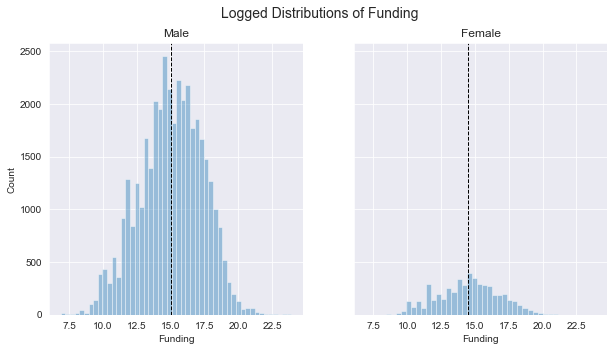

In [50]:
i = 0
VAR = variables[i]
LABEL = labels[i]

fig, axes = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)
plt.suptitle(f'Logged Distributions of {LABEL}', fontsize=14)

m_data = np.log(male_data[male_data[VAR] > 1][VAR])
sns.distplot(m_data, kde=False, ax=axes[0])
axes[0].axvline(m_data.mean(), color='k', linestyle='dashed', linewidth=1)

f_data = np.log(fem_data[fem_data[VAR] > 1][VAR])
sns.distplot(f_data, kde=False, ax=axes[1])
axes[1].axvline(f_data.mean(), color='k', linestyle='dashed', linewidth=1)
    
axes[0].set_xlabel(LABEL)
axes[0].set_ylabel('Count')
axes[0].set_title('Male')
axes[1].set_xlabel(LABEL)
axes[1].set_title('Female');

### `jobs_created`

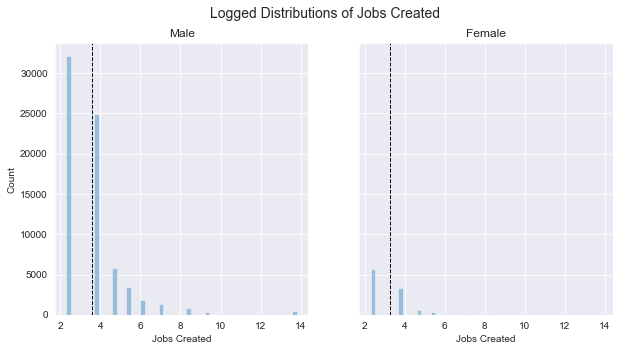

In [51]:
i = 1
VAR = variables[i]
LABEL = labels[i]

fig, axes = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)
plt.suptitle(f'Logged Distributions of {LABEL}', fontsize=14)

m_data = np.log(male_data[male_data[VAR].notnull()][VAR])
sns.distplot(m_data, kde=False, ax=axes[0])
axes[0].axvline(m_data.mean(), color='k', linestyle='dashed', linewidth=1)

f_data = np.log(fem_data[fem_data[VAR].notnull()][VAR])
sns.distplot(f_data, kde=False, ax=axes[1])
axes[1].axvline(f_data.mean(), color='k', linestyle='dashed', linewidth=1)
    
axes[0].set_xlabel(LABEL)
axes[0].set_ylabel('Count')
axes[0].set_title('Male')
axes[1].set_xlabel(LABEL)
axes[1].set_title('Female');

### `patents`

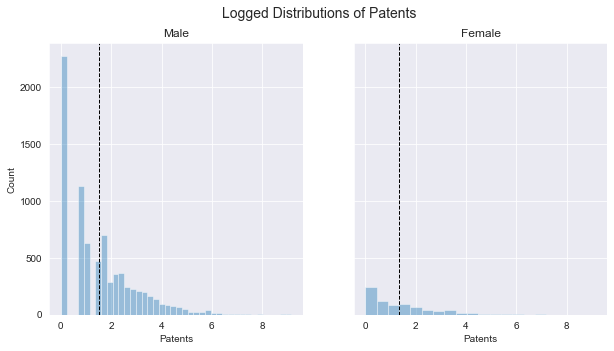

In [52]:
i = 2
VAR = variables[i]
LABEL = labels[i]

fig, axes = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)
plt.suptitle(f'Logged Distributions of {LABEL}', fontsize=14)

m_data = np.log(male_data[male_data[VAR]>0][VAR])
sns.distplot(m_data, kde=False, ax=axes[0])
axes[0].axvline(m_data.mean(), color='k', linestyle='dashed', linewidth=1)

f_data = np.log(fem_data[fem_data[VAR]>0][VAR])
sns.distplot(f_data, kde=False, ax=axes[1])
axes[1].axvline(f_data.mean(), color='k', linestyle='dashed', linewidth=1)
    
axes[0].set_xlabel(LABEL)
axes[0].set_ylabel('Count')
axes[0].set_title('Male')
axes[1].set_xlabel(LABEL)
axes[1].set_title('Female');

# 1.3.0 - Metro-level: Consolidate Metros and engineer Metro-specific features

In this section, we will:  
 
- Combine Metropolitans
- Add Metropolitan-specific features
- Calculate mean, median, and std per population per Metropolitan
- Save data

### Group entrepreneur-level data by Metropolitan

In [53]:
# Get metro_df
metro_df = entrepreneur_df.groupby('metro')[
    'funding',
    'jobs_created',
    'patents',
    'ipo'
].sum().reset_index()

## 1.3.1 - Create mapping of combined Metros

In [54]:
# View all columns
pd.set_option('display.max_columns', None)

In [55]:
COMB_CITY_METRO_DICT = {}

#### Alabama

In [56]:
# Birmingham
COMB_CITY_METRO_DICT['Birmingham, AL'] = [
    'Birmingham-Hoover, AL',
    'Cullman, AL',
    'Talladega-Sylacauga, AL',
]

# Montgomery
COMB_CITY_METRO_DICT['Montgomery, AL'] = [
    'Montgomery, AL',
]

# Hunstville
COMB_CITY_METRO_DICT['Huntsville, AL'] = [
    'Huntsville, AL',
    'Decatur, AL',
    'Albertville, AL',
]

# Mobile
COMB_CITY_METRO_DICT['Mobile, AL'] = [
    'Mobile, AL',
    'Daphne-Fairhope-Foley, AL',
]

# Tuscaloosa
COMB_CITY_METRO_DICT['Tuscaloosa, AL'] = [
    'Tuscaloosa, AL',
]

#### Alaska

In [57]:
# Anchorage
COMB_CITY_METRO_DICT['Anchorage, AK'] = [
    'Anchorage, AK'
]

#### Arizona

In [58]:
# Phoenix
COMB_CITY_METRO_DICT['Phoenix, AZ'] = [
    'Phoenix-Mesa-Scottsdale, AZ',
]

# Tucson
COMB_CITY_METRO_DICT['Tucson, AZ'] = [
    'Tucson, AZ',
    'Nogales, AZ',
]

#### Arkansas

In [59]:
# Little Rock
COMB_CITY_METRO_DICT['Little Rock, AR'] = [
    'Little Rock-North Little Rock-Conway, AR',
    'Pine Bluff, AR',
    'Searcy, AR',
]

#### California

In [65]:
# Los Angeles
COMB_CITY_METRO_DICT['Los Angeles, CA'] = [
    'Los Angeles-Long Beach-Santa Ana, CA',
    'Riverside-San Bernardino-Ontario, CA',
    'Oxnard-Thousand Oaks-Ventura, CA',
    'Santa Barbara-Santa Maria-Goleta, CA',
]

# San Francisco
COMB_CITY_METRO_DICT['San Francisco, CA'] = [
    'San Francisco-Oakland-Hayward, CA',
    'San Jose-Sunnyvale-Santa Clara, CA',
    'Santa Rosa-Petaluma, CA',
    'Vallejo-Fairfield, CA',
    'Santa Cruz-Watsonville, CA',
    'Napa, CA'
]

# San Diego
COMB_CITY_METRO_DICT['San Diego, CA'] = [
    'San Diego-Carlsbad-San Marcos, CA',
]

# Sacramento
COMB_CITY_METRO_DICT['Sacramento, CA'] = [
    'Sacramento-Arden Arcade-Roseville, CA',
    'Yuba City, CA',
    'Stockton, CA',
]

# Fresno-Bakersfield
COMB_CITY_METRO_DICT['Fresno-Bakersfield, CA'] = [
    'Fresno, CA',
    'Madera, CA',
    'Bakersfield, CA',
    'Merced, CA',
]

#### Colorado

In [66]:
# Denver
COMB_CITY_METRO_DICT['Denver, CO'] = [
    'Denver-Aurora-Lakewood, CO',
    'Boulder, CO',
    'Greeley, CO',
]

# Colorado Springs
COMB_CITY_METRO_DICT['Colorado Springs, CO'] = [
    'Colorado Springs, CO',
]

#### Connecticut

In [67]:
# Hartford
COMB_CITY_METRO_DICT['Hartford, CT'] = [
    'Hartford-West Hartford-East Hartford, CT',
    'Willimantic, CT',
    'Norwich-New London, CT'
]

#### Florida

In [68]:
# Jacksonville
COMB_CITY_METRO_DICT['Jacksonville, FL'] = [
    'Jacksonville, FL',
    'Palatka, FL',
    'St Marys, GA',
]

# Miami
COMB_CITY_METRO_DICT['Miami, FL'] = [
    'Miami-Fort Lauderdale-Pompano Beach, FL',
    'Port St Lucie, FL',
    'Sebastian-Vero Beach',
    'Okeechobee, FL',
]

# Tampa
COMB_CITY_METRO_DICT['Tampa, FL'] = [
    'Tampa-St Petersburg-Clearwater, FL',
]

# Orlando
COMB_CITY_METRO_DICT['Orlando, FL'] = [
    'Orlando-Kissimmee, FL',
    'Deltona-Daytona Beach-Ormond Beach, FL',
    'Palm Coast, FL',
    'The Villages, FL',
]

# Tallahassee
COMB_CITY_METRO_DICT['Tallahassee, FL'] = [
    'Tallahassee, FL',
    'Bainbridge, GA',
]

#### Georgia

In [69]:
# Atlanta
COMB_CITY_METRO_DICT['Atlanta, GA'] = [
    'Atlanta-Sandy Springs-Roswell, GA',
    'Athens-Clarke, GA',
    'Gainesville, GA',
    'LaGrange, GA',
    'Jefferson, GA',
    'Calhoun, GA',
    'Cedartown, GA',
    'Thomaston, GA',
]

# Savannah
COMB_CITY_METRO_DICT['Savannah, GA'] = [
    'Savannah, GA',
    'Hinesville, GA',
    'Statesboro, GA',
]

# Augusta
COMB_CITY_METRO_DICT['Augusta, GA'] = [
    'Augusta-Richmond, GA-SC'
]

# Columbus
COMB_CITY_METRO_DICT['Columbus, GA'] = [
    'Columbus, GA-AL',
    'Auburn-Opelika, AL',
    'Valley, AL',
]

# Macon
COMB_CITY_METRO_DICT['Macon, GA'] = [
    'Macon, GA',
    'Warner Robins, GA',
]

#### Hawaii

In [70]:
# Honolulu
COMB_CITY_METRO_DICT['Honolulu, HI'] = [
    'Honolulu, HI'
]

#### Idaho

In [71]:
# Boise
COMB_CITY_METRO_DICT['Boise, ID'] = [
    'Boise City-Nampa, ID',
    'Ontario, OR-ID',
    'Mountain Home, ID',
]

# Idaho Falls
COMB_CITY_METRO_DICT['Idaho Falls, ID'] = [
    'Idaho Falls, ID',
    'Rexburg, ID',
    'Blackfoot, ID',
]

#### Illinois

In [72]:
# Chicago
COMB_CITY_METRO_DICT['Chicago, IL'] = [
    'Chicago-Naperville-Joliet, IL-IN-WI',
    'Kankakee-Bradley, IL',
    'Michigan City-La Porte, IN',
]

#### Indiana

In [73]:
# Indianapolis
COMB_CITY_METRO_DICT['Indianapolis, IN'] = [
    'Indianapolis-Carmel, IN',
    'Anderson, IN',
    'Columbus, IN',
    'New Castle, IN',
    'Crawfordsville, IN',
    'North Vernon, IN',
]

# Fort Wayne
COMB_CITY_METRO_DICT['Fort Wayne, IN'] = [
    'Fort Wayne, IN',
    'Kendallville, IN',
    'Auburn, IN',
    'Huntington, IN',
    'Decatur, IN',
]

#### Iowa

In [74]:
# Des Moines
COMB_CITY_METRO_DICT['Des Moines, IA'] = [
    'Des Moines-West Des Moines, IA',
    'Newton, IA',
    'Pella, IA',
]

#### Kansas

In [75]:
# Wichita
COMB_CITY_METRO_DICT['Wichita, KS'] = [
    'Wichita, KS',
    'Winfield, KS'
]

#### Kentucky

In [76]:
# Louisville
COMB_CITY_METRO_DICT['Louisville, KY'] = [
    'Louisville-Jefferson, KY-IN',
    'Elizabethtown, KY',
    'Scottsburg, IN',
]

# Lexington
COMB_CITY_METRO_DICT['Lexington, KY'] = [
    'Lexington-Fayette, KY',
    'Richmond-Berea, KY',
    'Frankfort, KY',
    'Mount Sterling, KY',
]

#### Louisiana

In [77]:
# New Orleans
COMB_CITY_METRO_DICT['New Orleans, LA'] = [
    'New Orleans-Metairie, LA',
    'Hammond, LA',
    'Bogalusa, LA',
]

# Baton Rouge
COMB_CITY_METRO_DICT['Baton Rouge, LA'] = [
    'Baton Rouge, LA',
]

# Shreveport
COMB_CITY_METRO_DICT['Shreveport, LA'] = [
    'Shreveport-Bossier City, LA'
]

#### Maryland

In [78]:
# Baltimore
COMB_CITY_METRO_DICT['Baltimore, MD'] = [
    'Baltimore-Towson, MD',
    'Baltimore, MD',
]

#### Massachusetts

In [79]:
# Boston
COMB_CITY_METRO_DICT['Boston, MA'] = [
    'Boston-Cambridge-Newton, MA-NH',
    'Providence-New Bedford-Fall River, RI-MA',
    'Worcester, MA',
    'Manchester-Nashua, NH',
    'Concord, NH',
    'Laconia, NH',
]

#### Michigan

In [80]:
# Detroit
COMB_CITY_METRO_DICT['Detroit, MI'] = [
    'Detroit-Warren-Dearborn, MI',
    'Flint, MI',
    'Ann Arbor, MI',
    'Monroe, MI',
    'Adrian, MI',
]

# Grand Rapids
COMB_CITY_METRO_DICT['Grand Rapids, MI'] = [
    'Grand Rapids-Wyoming, MI',
    'Muskegon, MI',
    'Holland, MI',
    'Ionia, MI',
    'Big Rapids, MI',
]

#### Minnesota

In [81]:
# Minneapolis
COMB_CITY_METRO_DICT['Minneapolis, MN'] = [
    'Minneapolis-St Paul-Bloomington, MN-WI',
    'St Cloud, MN',
    'Faribault-Northfield, MN',
    'Red Wing, MN',
    'Hutchinson, MN',
]

#### Missouri

In [82]:
# Kansas City
COMB_CITY_METRO_DICT['Kansas City, MO'] = [
    'Kansas City, MO-KS',
    'St Joseph, MO-KS',
    'Lawrence, KS',
    'Warrensburg, MO',
    'Ottawa, KS',
    'Atchison, KS',
]

# St. Louis
COMB_CITY_METRO_DICT['St. Louis, MO'] = [
    'St Louis, MO-IL',
    'Farmington, MO',
    'Centralia, IL',
]

# Springfield
COMB_CITY_METRO_DICT['Springfield, MO'] = [
    'Springfield, MO',
]

#### Nebraska

In [83]:
# Omaha
COMB_CITY_METRO_DICT['Omaha, NE'] = [
    'Omaha-Council Bluffs, NE-IA',
    'Fremont, NE',
]

# Lincoln
COMB_CITY_METRO_DICT['Lincoln, NE'] = [
    'Lincoln, NE',
]

#### Nevada

In [84]:
# Las Vegas
COMB_CITY_METRO_DICT['Las Vegas, NV'] = [
    'Las Vegas–Paradise, NV',
    'Pahrump, NV',
    'Lake Havasu City-Kingman, AZ',
]

# Reno
COMB_CITY_METRO_DICT['Reno, NV'] = [
    'Reno–Sparks, NV',
    'Carson City, NV',
    'Fernley, NV',
    'Gardnerville Ranchos, NV µSA',
    'Truckee-Grass Valley, CA',
]

#### New Mexico

In [85]:
# Albuquerque
COMB_CITY_METRO_DICT['Albuquerque, NM'] = [
    'Albuquerque, NM',
    'Santa Fe, NM',
    'Española, NM',
    'Las Vegas, NM',
    'Grants, NM',
    'Los Alamos, NM'
]

#### New York

In [86]:
# New York City
COMB_CITY_METRO_DICT['New York City, NY'] = [
    'New York-Northern New Jersey-Long Island, NY-NJ-PA',
    'New York-Newark-Jersey City, NY-NJ-PA',
    'Bridgeport-Stamford-Norwalk, CT',
    'New Haven-Milford, CT',
    'Poughkeepsie-Newburgh-Middletown, NY',
    'Trenton-Ewing, NJ',
    'Trenton, NJ',
    'Torrington, CT',
    'Kingston, NY',
    'Allentown-Bethlehem-Easton, PA-NJ',
    'East Stroudsburg, PA',
]

# Buffalo
COMB_CITY_METRO_DICT['Buffalo, NY'] = [
    'Buffalo-Cheektowaga-Niagara Falls, NY',
    'Olean, NY',
]

# Rochester
COMB_CITY_METRO_DICT['Rochester, NY'] = [
    'Rochester, NY',
    'Batavia, NY',
    'Seneca Falls, NY',
]

# Syracuse
COMB_CITY_METRO_DICT['Syracuse, NY'] = [
    'Syracuse, NY',
    'Auburn, NY'
]

# Albany
COMB_CITY_METRO_DICT['Albany, NY'] = [
    'Albany-Schenectady-Troy, NY'
]

#### North Carolina

In [87]:
# Charlotte
COMB_CITY_METRO_DICT['Charlotte, NC'] = [
    'Charlotte-Concord-Gastonia, NC-SC',
    'Shelby, NC',
    'Albemarle, NC',
]

# Raleigh
COMB_CITY_METRO_DICT['Raleigh, NC'] = [
    'Raleigh, NC',
    'Durham-Chapel Hill, NC',
    'Dunn, NC',
    'Sanford, NC',
    'Oxford, NC',
    'Henderson, NC',
]

# Greensboro
COMB_CITY_METRO_DICT['Greensboro, NC'] = [
    'Greensboro-High Point, NC',
    'Winston-Salem, NC',
    'Burlington, NC',
    'Mount Airy, NC',
]

# Fayetteville
COMB_CITY_METRO_DICT['Fayetteville, NC'] = [
    'Fayetteville, NC',
    'Laurinburg, NC',
]

#### Ohio

In [88]:
# Dayton
COMB_CITY_METRO_DICT['Dayton, OH'] = [
    'Dayton, OH',
    'Springfield, OH',
    'Greenville, OH',
    'Sidney, OH',
    'Urbana, OH',
]

# Columbus
COMB_CITY_METRO_DICT['Columbus, OH'] = [
    'Columbus, OH',
    'Bellefontaine, OH',
    'Cambridge, OH',
    'Chillicothe, OH',
    'Marion, OH',
    'Mount Vernon, OH',
    'Washington Court House, OH',
    'Zanesville, OH',
]

# Cleveland
COMB_CITY_METRO_DICT['Cleveland, OH'] = [
    'Cleveland–Elyria, OH',
    'Akron, OH',
    'Canton–Massillon, OH',
    'Ashtabula, OH',
    'New Philadelphia-Dover, OH',
    'Norwalk, OH',
    'Sandusky, OH',
    'Wooster, OH',
]

# Cincinnati
COMB_CITY_METRO_DICT['Cincinnati, OH'] = [
    'Cincinnati, OH-KY-IN',
    'Wilmington, OH',
    'Maysville, KY',
]

# Toledo
COMB_CITY_METRO_DICT['Toledo, OH'] = [
    'Toledo, OH',
    'Port Clinton, OH',
]

#### Oklahoma

In [89]:
# Oklahoma City
COMB_CITY_METRO_DICT['Oklahoma City, OK'] = [
    'Oklahoma City, OK',
    'Shawnee, OK µSA',
]

# Tulsa
COMB_CITY_METRO_DICT['Tulsa, OK'] = [
    'Tulsa, OK',
    'Muskogee, OK µSA',
    'Bartlesville, OK µSA',
    'Tahlequah, OK µSA',
]

#### Oregon

In [90]:
# Portland
COMB_CITY_METRO_DICT['Portland, OR'] = [
    'Portland-Vancouver-Hillsboro, OR-WA',
    'Longview, WA',
    'Salem, OR',
]

# Medford
COMB_CITY_METRO_DICT['Medford, OR'] = [
    'Medford, OR',
    'Grants Pass, OR',
]

#### Pennsylvania

In [91]:
# Philadelphia
COMB_CITY_METRO_DICT['Philadelphia, PA'] = [
    'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD',
    'Reading, PA',
    'Vineland-Millville-Bridgeton, NJ',
]

# Pittsburgh
COMB_CITY_METRO_DICT['Pittsburgh, PA'] = [
    'Pittsburgh, PA',
    'Weirton-Steubenville, WV-OH',
    'New Castle, PA',
    'Indiana, PA',
]

#### South Carolina

In [92]:
# Greenville
COMB_CITY_METRO_DICT['Greenville, SC'] = [
    'Greenville-Anderson-Mauldin, SC',
    'Spartanburg, SC',
    'Greenwood, SC',
    'Seneca, SC',
    'Gaffney, SC',
    'Union, SC',
]

# Columbia
COMB_CITY_METRO_DICT['Columbia, SC'] = [
    'Columbia, SC',
    'Orangeburg, SC',
    'Newberry, SC',
]

#### Tennessee

In [93]:
# Nashville
COMB_CITY_METRO_DICT['Nashville, TN'] = [
    'Nashville-Davidson-Murfreesboro-Franklin, TN',
    'Columbia, TN',
]

# Memphis
COMB_CITY_METRO_DICT['Memphis, TN'] = [
    'Memphis, TN-MS-AR',
]

# Chattanooga
COMB_CITY_METRO_DICT['Chattanooga, TN'] = [
    'Chattanooga, TN-GA',
    'Dalton, GA',
    'Cleveland, TN',
    'Scottsboro, AL',
    'Athens, TN',
    'Dayton, TN',
]

# Knoxville
COMB_CITY_METRO_DICT['Knoxville, TN'] = [
    'Knoxville, TN',
    'Morristown, TN',
    'Sevierville, TN',
    'Harriman, TN',
    'La Follette, TN',
    'Newport, TN',
]

# Clarksville
COMB_CITY_METRO_DICT['Clarksville, TN'] = [
    'Clarksville, TN-KY'
]

#### Texas

In [94]:
# Houston
COMB_CITY_METRO_DICT['Houston, TX'] = [
    'Houston-Sugar Land-Baytown, TX',
    'Huntsville, TX',
    'Bay City, TX',
]

# San Antonio
COMB_CITY_METRO_DICT['San Antonio, TX'] = [
    'San Antonio, TX',
]

# Dallas
COMB_CITY_METRO_DICT['Dallas, TX'] = [
    'Dallas-Fort Worth-Arlington, TX',
    'Sherman-Denison, TX',
    'Athens, TX',
    'Granbury, TX',
    'Gainesville, TX',
    'Bonham, TX',
    'Mineral Wells, TX',
]

# Austin
COMB_CITY_METRO_DICT['Austin, TX'] = [
    'Austin-Round Rock, TX',
]

# El Paso
COMB_CITY_METRO_DICT['El Paso, TX'] = [
    'El Paso, TX',
]

# Corpus Christi
COMB_CITY_METRO_DICT['Corpus Christi, TX'] = [
    'Corpus Christi, TX',
    'Kingsville, TX',
]

# Laredo
COMB_CITY_METRO_DICT['Laredo, TX'] = [
    'Laredo, TX',
]

# Lubbock
COMB_CITY_METRO_DICT['Lubbock, TX'] = [
    'Lubbock, TX',
    'Levelland, TX',
]

#### Utah

In [95]:
# Salt Lake City
COMB_CITY_METRO_DICT['Salt Lake City, UT'] = [
    'Salt Lake City, UT',
    'Ogden-Clearfield, UT',
    'Provo-Orem, UT',
    'Summit Park, UT',
    'Heber, UT',
]

#### Virginia

In [98]:
# Virginia Beach
COMB_CITY_METRO_DICT['Virginia Beach, VA'] = [
    'Virginia Beach-Norfolk-Newport News, VA-NC',
]

# Richmond-Norfolk
COMB_CITY_METRO_DICT['Richmond-Norfolk, VA'] = [
    'Richmond, VA',
    'Virginia Beach-Norfolk-Newport News, VA-NC',
]

#### Washington

In [219]:
# Seattle
COMB_CITY_METRO_DICT['Seattle, WA'] = [
    'Seattle-Tacoma-Bellevue, WA',
    'Olympia, WA',
    'Bremerton-Silverdale, WA',
    'Mount Vernon-Anacortes, WA',
    'Oak Harbor, WA',
    'Centralia, WA',
    'Shelton, WA',
]

# Spokane
COMB_CITY_METRO_DICT['Spokane, WA'] = [
    'Spokane-Spokane Valley, WA',
    "Coeur d'Alene, ID",
]

#### Washington DC

In [220]:
# Washington DC
COMB_CITY_METRO_DICT['Washington, DC'] = [
    'Washington-Arlington-Alexandria, DC-VA-MD-WV',
    'Winchester, VA-WV',
    'Lexington Park, MD',
    'Culpeper, VA',
]

#### Wisconsin

In [221]:
# Milwaukee
COMB_CITY_METRO_DICT['Milwaukee, WI'] = [
    'Milwaukee-Waukesha-West Allis, WI',
    'Racine, WI',
    'Whitewater, WI',
    'Beaver Dam, WI',
    'Watertown-Fort Atkinson, WI'
]

# Madison
COMB_CITY_METRO_DICT['Madison, WI'] = [
    'Madison, WI',
    'Janesville, WI',
    'Baraboo, WI',
]

These states do not have any major cities that belong to them:
- New Jersey
- Delaware
- New Hampshire
- Rhode Island
- Maine
- Montana
- Vermont
- North Dakota
- South Dakota
- West Virginia
- Mississippi
- Wyoming

## Save mapping

In [222]:
# Save mapping
with open(MAP_DIR / 'COMB_CITY_METRO_DICT.json', 'w') as f:
    json.dump(COMB_CITY_METRO_DICT, f, sort_keys=True, indent=4)

## 1.3.2 - Combine Metropolitans

In [223]:
# Map metros to comb_metro name
for i in metro_df.index:
    metro = metro_df.at[i, 'metro']
    for k in COMB_CITY_METRO_DICT.keys():
        if metro in COMB_CITY_METRO_DICT[k]:
            metro_df.at[i, 'comb_metro'] = k

In [225]:
# View unmapped Metros and their respective populations
unmapped_metros = metro_df[metro_df.comb_metro.isnull()].reset_index(drop=True)
for i in unmapped_metros.index:
    metro = unmapped_metros.at[i, 'metro']
    state_abrev = metro.split(', ')[1]
    for k, v in STATE_MAPPING.items():
        if v == state_abrev:
            state = k
    try:
        pop = STATE_STAT_AREA_POPULATION_MAPPING[state][metro]
        if int(pop) < 600000:
            print(metro, '-'*(40-len(metro)), pop)
        else:
            if int(pop) > 800000:
                print(metro, '-'*(40-len(metro)), pop, '++RLY HIGH++')
            else:
                print(metro, '-'*(40-len(metro)), pop, '+HIGH+')
    except KeyError:
        print(metro, '-'*(40-len(metro)), 'pop unknown')

Aberdeen, SD ---------------------------- 40602
Abilene, TX ----------------------------- 158063
Ada, OK µSA ----------------------------- pop unknown
Albany-Lebanon, OR ---------------------- 116672
Alexandria, LA -------------------------- 150080
Alpena, MI ------------------------------ 29598
Altoona, PA ----------------------------- 127089
Americus, GA ---------------------------- 36395
Ames, IA -------------------------------- 80145
Anniston-Oxford, AL --------------------- 118572
Appleton, WI ---------------------------- 225666
Arkadelphia, AR ------------------------- 22858
Asheville, NC --------------------------- 446840
Athens, OH ------------------------------ 61860
Atlantic City-Hammonton, NJ ------------- 274549
Augusta-Waterville, ME ------------------ 122151
Bakersfield, CA ------------------------- 851710 ++RLY HIGH++
Bangor, ME ------------------------------ 153923
Barnstable Town, MA --------------------- 215888
Barre, VT ------------------------------- 59534
Batesvill

In [226]:
# Drop metros not mapped (these are the small cities)
metro_df = metro_df[metro_df.comb_metro.notnull()].reset_index(drop=True)

In [227]:
metro_df.shape

(220, 6)

In [228]:
# Groupby combined metros and sum 
metro_df = metro_df.groupby('comb_metro').sum().reset_index()

In [229]:
metro_df.head()

,comb_metro,funding,jobs_created,patents,ipo
0,"Albany, NY",149966736,16610.0,400,3
1,"Albuquerque, NM",846996756,6890.0,329,0
2,"Anchorage, AK",6928554,620.0,4,0
3,"Atlanta, GA",20284303563,12314260.0,2636,31
4,"Augusta, GA",34116970,340.0,0,0


## 1.3.3 - Add Metropolitan-specific features

Add Metropolitan-specific features:  
  - `population`
  - `gdp_per_capita`
  - `latitude`
  - `longitude`

### Create dictionary of our Metropolitans to the Census Bureau's Metropolitans

In [230]:
METRO_TO_METRO_MAPPING = {}

In [231]:
# Read in GDP per Metro data
xlsx = pd.ExcelFile(EXT_DIR / 'gdp_metro0918.xlsx')
metro_gdp_df = pd.read_excel(xlsx, 'Table1')

# Rename columns
metro_gdp_df = metro_gdp_df.rename(columns={'Table 1. Current-Dollar Gross Domestic Product (GDP) by Metropolitan Area, 2012-2017':'Metro'})

In [232]:
# Get all Metros with exact match
for i in metro_df.index:
    comb_metro = metro_df.at[i, 'comb_metro']
    for metro1 in COMB_CITY_METRO_DICT[comb_metro]:
        for metro2 in metro_gdp_df['Metro'][3:]:
            Ratio = fuzz.ratio(metro1.lower(), metro2.lower())
            if Ratio == 100:
                METRO_TO_METRO_MAPPING[metro1] = metro2

In [233]:
# Get list of all metros
all_metros = []
for each in COMB_CITY_METRO_DICT.values():
    all_metros += each

In [234]:
# Get all close matches
for i in metro_df.index:
    comb_metro = metro_df.at[i, 'comb_metro']
    for metro1 in COMB_CITY_METRO_DICT[comb_metro]:
        if metro1 in np.setdiff1d(all_metros, list(METRO_TO_METRO_MAPPING.keys())):
            for metro2 in metro_gdp_df['Metro'][3:]:
                Ratio = fuzz.ratio(metro1.lower(), metro2.lower())
                if Ratio >= 86:
                    METRO_TO_METRO_MAPPING[metro1] = metro2

In [235]:
# Get more close matches
for i in metro_df.index:
    comb_metro = metro_df.at[i, 'comb_metro']
    for metro1 in COMB_CITY_METRO_DICT[comb_metro]:
        if metro1 in np.setdiff1d(all_metros, list(METRO_TO_METRO_MAPPING.keys())):
            matches = []
            matches_ratio = []
            for metro2 in metro_gdp_df['Metro'][3:]:
                Ratio = fuzz.ratio(metro1.lower(), metro2.lower())
                if Ratio >= 78:
                    if metro1 not in ['Eugene-Springfield, OR', 'Danville, VA', 'Washington, NC']:
                        matches.append(metro2)
                        matches_ratio.append(Ratio)
            if len(matches) > 0:
                metro2 = matches[matches_ratio.index(max(matches_ratio))]
                METRO_TO_METRO_MAPPING[metro1] = metro2

In [240]:
# Look at close matches
for i in metro_df.index:
    comb_metro = metro_df.at[i, 'comb_metro']
    for metro1 in COMB_CITY_METRO_DICT[comb_metro]:
        if metro1 in np.setdiff1d(all_metros, list(METRO_TO_METRO_MAPPING.keys())):
            print(metro1)
            print('..............')
            count = 0
            for metro2 in metro_gdp_df['Metro'][3:]:
                Ratio = fuzz.ratio(metro1.lower(), metro2.lower())
                if Ratio >= 70:
                    count += 1
                    print(metro2)
                    print(Ratio)
            print('C --', count)
            print()

Española, NM
..............
C -- 0

Las Vegas, NM
..............
Las Cruces, NM
74
C -- 1

Grants, NM
..............
C -- 0

Los Alamos, NM
..............
C -- 0

LaGrange, GA
..............
C -- 0

Jefferson, GA
..............
Jefferson City, MO
71
C -- 1

Calhoun, GA
..............
Dalton, GA
76
Macon, GA
70
C -- 2

Thomaston, GA
..............
Dalton, GA
70
Macon, GA
73
C -- 2

Baltimore, MD
..............
C -- 0

Cullman, AL
..............
C -- 0

Talladega-Sylacauga, AL
..............
C -- 0

Ontario, OR-ID
..............
C -- 0

Mountain Home, ID
..............
C -- 0

Providence-New Bedford-Fall River, RI-MA
..............
C -- 0

Concord, NH
..............
C -- 0

Laconia, NH
..............
C -- 0

Olean, NY
..............
C -- 0

Shelby, NC
..............
Asheville, NC
70
C -- 1

Albemarle, NC
..............
C -- 0

Scottsboro, AL
..............
C -- 0

Athens, TN
..............
C -- 0

Kankakee-Bradley, IL
..............
Kankakee, IL
75
C -- 1

Maysville, KY
..............
Cl

In [241]:
# METRO_TO_METRO_MAPPING[our city] = alternate spelling
METRO_TO_METRO_MAPPING['Baltimore, MD'] = 'Baltimore-Columbia-Towson, MD'
METRO_TO_METRO_MAPPING['Anderson, IN'] = 'Indianapolis-Carmel-Anderson, IN'
METRO_TO_METRO_MAPPING['Bend, OR'] = 'Bend-Redmond, OR'
METRO_TO_METRO_MAPPING['Houston-Sugar Land-Baytown, TX'] = 'Houston-The Woodlands-Sugar Land, TX'
METRO_TO_METRO_MAPPING['New York-Northern New Jersey-Long Island, NY-NJ-PA'] = 'New York-Newark-Jersey City, NY-NJ-PA'
METRO_TO_METRO_MAPPING['North Port-Bradenton-Sarasota, FL'] = 'North Port-Sarasota-Bradenton, FL'
METRO_TO_METRO_MAPPING['Providence-New Bedford-Fall River, RI-MA'] = 'Providence-Warwick, RI-MA'
METRO_TO_METRO_MAPPING['Reno–Sparks, NV'] = 'Reno, NV'
METRO_TO_METRO_MAPPING['Sacramento-Arden Arcade-Roseville, CA'] = 'Sacramento--Roseville--Arden-Arcade, CA'
METRO_TO_METRO_MAPPING['San Antonio, TX'] = 'San Antonio-New Braunfels, TX'
METRO_TO_METRO_MAPPING['Santa Barbara-Santa Maria-Goleta, CA'] = 'Santa Maria-Santa Barbara, CA'
METRO_TO_METRO_MAPPING['Santa Rosa-Petaluma, CA'] = 'Santa Rosa, CA'
METRO_TO_METRO_MAPPING['Warrensburg, MO'] = 'Kansas City, MO-KS'
METRO_TO_METRO_MAPPING['Kankakee-Bradley, IL'] = 'Kankakee, IL'
METRO_TO_METRO_MAPPING['Elizabethtown, KY'] = 'Elizabethtown-Fort Knox, KY'
METRO_TO_METRO_MAPPING['Olympia, WA'] = 'Olympia-Tumwater, WA'
METRO_TO_METRO_MAPPING['Lexington Park, MD'] = 'California-Lexington Park, MD'

In [242]:
# How many are not matched? -> I've looked through these and they are small cities
len(np.setdiff1d(all_metros, list(METRO_TO_METRO_MAPPING.keys())))

118

This is fine because the Metros may already be incorporated to other Metros that matched (e.g. Poughkeepsie-Newburgh-Middletown, NY is already part of New York-Northern New Jersey-Long Island, NY-NJ-PA.

### `population`

In [243]:
# Read in population data of combined metros
metro_pop_df = pd.read_csv(EXT_DIR / 'cbsa-est2017-alldata.csv', encoding='ISO-8859-1')
metro_pop_df = metro_pop_df[['NAME', 'LSAD', 'POPESTIMATE2017']]

In [244]:
# Get Metros only
metro_pop_df = metro_pop_df.loc[metro_pop_df.LSAD == 'Metropolitan Statistical Area'].reset_index(drop='True')

In [245]:
# Create dict of population per combined Metro
POPULATION_MAPPING = {}

for key, value in COMB_CITY_METRO_DICT.items():
    comb_metro = key
    metros = value
    print('....', comb_metro, '....')
    # If there are multiple metros
    if comb_metro != metros[0]:
        pop_total = 0
        for metro in metros:
            population = 0
            # Get the population of this metro
            try:
                new_metro = METRO_TO_METRO_MAPPING[metro]
                print(metro, '-->', new_metro)
                try:
                    population = metro_pop_df.loc[metro_pop_df.NAME == new_metro]['POPESTIMATE2017'].tolist()[0]
                    pop_total += population
                    print(population, '-->', pop_total)
                except IndexError:
                    print(metro, '-', 'NO POP')
            except KeyError:
                print(metro, '-', 'NO MATCH')
                pass
        POPULATION_MAPPING[comb_metro] = pop_total
    # If there is only one metro
    else:
        population = 0
        # Get the population
        try:
            new_metro = METRO_TO_METRO_MAPPING[comb_metro]
            print(comb_metro, '-->', new_metro)
            try:
                population = metro_pop_df.loc[metro_pop_df.NAME == new_metro]['POPESTIMATE2017'].tolist()[0]
                print(population)
            except IndexError:
                print(comb_metro, '-', 'NO POP')
            POPULATION_MAPPING[comb_metro] = population
        except KeyError:
            print(comb_metro, '-', 'NO MATCH')
            POPULATION_MAPPING[comb_metro] = 'not found'
    print('final pop:', POPULATION_MAPPING[comb_metro])
    print()

.... Birmingham, AL ....
Birmingham-Hoover, AL --> Birmingham-Hoover, AL
1149807 --> 1149807
Cullman, AL - NO MATCH
Talladega-Sylacauga, AL - NO MATCH
final pop: 1149807

.... Montgomery, AL ....
Montgomery, AL --> Montgomery, AL
373903
final pop: 373903

.... Huntsville, AL ....
Huntsville, AL --> Huntsville, AL
455448
final pop: 455448

.... Mobile, AL ....
Mobile, AL --> Mobile, AL
413955
final pop: 413955

.... Tuscaloosa, AL ....
Tuscaloosa, AL --> Tuscaloosa, AL
242799
final pop: 242799

.... Anchorage, AK ....
Anchorage, AK --> Anchorage, AK
400888
final pop: 400888

.... Phoenix, AZ ....
Phoenix-Mesa-Scottsdale, AZ --> Phoenix-Mesa-Scottsdale, AZ
4737270 --> 4737270
final pop: 4737270

.... Tucson, AZ ....
Tucson, AZ --> Tucson, AZ
1022769
final pop: 1022769

.... Little Rock, AR ....
Little Rock-North Little Rock-Conway, AR --> Little Rock-North Little Rock-Conway, AR
738344 --> 738344
Pine Bluff, AR --> Pine Bluff, AR
90963 --> 829307
Searcy, AR - NO MATCH
final pop: 829307



1136856 --> 1136856
Olean, NY - NO MATCH
final pop: 1136856

.... Rochester, NY ....
Rochester, NY --> Rochester, NY
1077948
final pop: 1077948

.... Syracuse, NY ....
Syracuse, NY --> Syracuse, NY
654841
final pop: 654841

.... Albany, NY ....
Albany-Schenectady-Troy, NY --> Albany-Schenectady-Troy, NY
886188 --> 886188
final pop: 886188

.... Charlotte, NC ....
Charlotte-Concord-Gastonia, NC-SC --> Charlotte-Concord-Gastonia, NC-SC
2525305 --> 2525305
Shelby, NC - NO MATCH
Albemarle, NC - NO MATCH
final pop: 2525305

.... Raleigh, NC ....
Raleigh, NC --> Raleigh, NC
1335079
final pop: 1335079

.... Greensboro, NC ....
Greensboro-High Point, NC --> Greensboro-High Point, NC
761184 --> 761184
Winston-Salem, NC --> Winston-Salem, NC
667733 --> 1428917
Burlington, NC --> Burlington, NC
162391 --> 1591308
Mount Airy, NC - NO MATCH
final pop: 1591308

.... Fayetteville, NC ....
Fayetteville, NC --> Fayetteville, NC
386662
final pop: 386662

.... Dayton, OH ....
Dayton, OH --> Dayton, OH
80

In [246]:
#comb_metro_population

In [247]:
# Create population column using dict from above
metro_df['population'] = metro_df['comb_metro'].replace(POPULATION_MAPPING)

###  `gdp_2017`

In [248]:
metro_gdp_df.head()

,Metro,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,NaN,Millions of dollars,NaN,NaN,NaN,NaN,NaN,2017 Rank*
1,NaN,2012,2013.0,2014.0,2015.0,2016.0,2017.0,NaN
2,U.S. metropolitan areas,14485166,14966839.0,15628087.0,16358498.0,16857169.0,17547902.0,.......
3,"Abilene, TX",6397,6922.0,7436.0,6863.0,6659.0,7289.0,247
4,"Akron, OH",30011,31308.0,33445.0,35125.0,35700.0,36518.0,78


In [249]:
# Create mapping of Metro to GDP in 2017
GDP_MAPPING = dict(zip(metro_gdp_df['Metro'], metro_gdp_df['Unnamed: 6']))

In [250]:
missing_gdp = []
for i in metro_df.index:
    comb_metro = metro_df.at[i, 'comb_metro']
    population = metro_df.at[i, 'population']
    print(comb_metro)
    print('--------')
    total_gdp = 0
    # For each area in the combined metro
    for metro in COMB_CITY_METRO_DICT[comb_metro]:
        print(metro)
        # Get gdp
        try:
            new_metro = METRO_TO_METRO_MAPPING[metro]
            gdp = GDP_MAPPING[new_metro]
            total_gdp += int(gdp)
        except KeyError:
            missing_gdp.append(metro)
            pass
    # Calculate gdp per capita
    metro_df.at[i, 'gdp'] = total_gdp
    gdp_per_capita = np.round(total_gdp*1000000/population, 2)
    metro_df.at[i, 'gdp_per_capita'] = gdp_per_capita
    print('--------')
    print('GDP per capita: ${:,}'.format(gdp_per_capita))
    print()

Albany, NY
--------
Albany-Schenectady-Troy, NY
--------
GDP per capita: $61,275.94

Albuquerque, NM
--------
Albuquerque, NM
Santa Fe, NM
Española, NM
Las Vegas, NM
Grants, NM
Los Alamos, NM
--------
GDP per capita: $56,336.37

Anchorage, AK
--------
Anchorage, AK
--------
GDP per capita: $69,752.65

Atlanta, GA
--------
Atlanta-Sandy Springs-Roswell, GA
Athens-Clarke, GA
Gainesville, GA
LaGrange, GA
Jefferson, GA
Calhoun, GA
Cedartown, GA
Thomaston, GA
--------
GDP per capita: $63,974.36

Augusta, GA
--------
Augusta-Richmond, GA-SC
--------
GDP per capita: $40,648.1

Austin, TX
--------
Austin-Round Rock, TX
--------
GDP per capita: $70,303.48

Baltimore, MD
--------
Baltimore-Towson, MD
Baltimore, MD
--------
GDP per capita: $68,435.19

Baton Rouge, LA
--------
Baton Rouge, LA
--------
GDP per capita: $65,920.29

Birmingham, AL
--------
Birmingham-Hoover, AL
Cullman, AL
Talladega-Sylacauga, AL
--------
GDP per capita: $56,142.47

Boise, ID
--------
Boise City-Nampa, ID
Ontario, OR-

/Users/alexandrasmith/miniconda3/envs/impact-index/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in long_scalars


Currently, I am aggregating the total population and total gdp of a combined Metro, and then creating `gdp_per_capita` from that. However, for certain smaller cities for which we do not have data on gdp, we may want to exclude their population numbers from the total population and `gdp_per_capita` calculation.

In [251]:
# Cities for which we don't have gdp data, and their respective populations
missing_gdp

['Española, NM',
 'Las Vegas, NM',
 'Grants, NM',
 'Los Alamos, NM',
 'LaGrange, GA',
 'Jefferson, GA',
 'Calhoun, GA',
 'Thomaston, GA',
 'Cullman, AL',
 'Talladega-Sylacauga, AL',
 'Ontario, OR-ID',
 'Mountain Home, ID',
 'Concord, NH',
 'Laconia, NH',
 'Olean, NY',
 'Shelby, NC',
 'Albemarle, NC',
 'Scottsboro, AL',
 'Athens, TN',
 'Maysville, KY',
 'Ashtabula, OH',
 'New Philadelphia-Dover, OH',
 'Norwalk, OH',
 'Sandusky, OH',
 'Wooster, OH',
 'Orangeburg, SC',
 'Newberry, SC',
 'Valley, AL',
 'Bellefontaine, OH',
 'Cambridge, OH',
 'Chillicothe, OH',
 'Mount Vernon, OH',
 'Washington Court House, OH',
 'Zanesville, OH',
 'Kingsville, TX',
 'Athens, TX',
 'Granbury, TX',
 'Bonham, TX',
 'Mineral Wells, TX',
 'Sidney, OH',
 'Urbana, OH',
 'Newton, IA',
 'Pella, IA',
 'Adrian, MI',
 'Laurinburg, NC',
 'Kendallville, IN',
 'Auburn, IN',
 'Huntington, IN',
 'Holland, MI',
 'Ionia, MI',
 'Big Rapids, MI',
 'Mount Airy, NC',
 'Greenwood, SC',
 'Seneca, SC',
 'Gaffney, SC',
 'Union, SC',

In [254]:
metro_df.sort_values(by='gdp_per_capita', ascending=False).reset_index(drop=True)

,comb_metro,funding,jobs_created,patents,ipo,population,gdp,gdp_per_capita
0,"Macon, GA",8887992,290.0,20,0,0,16974.0,inf
1,"Salt Lake City, UT",17489967278,4197970.0,2820,17,1203105,139902.0,116284.11
2,"San Francisco, CA",715177919043,123644170.0,158780,491,8092365,850917.0,105150.60
3,"Raleigh, NC",10566501662,10100650.0,2688,16,1335079,126762.0,94947.19
4,"Des Moines, IA",93464981,3800.0,4,1,645911,57151.0,88481.23
5,"Madison, WI",2106877278,2022850.0,283,1,654230,56464.0,86306.04
6,"Seattle, WA",46589063894,20342010.0,13164,49,4539667,387115.0,85273.88
7,"Washington, DC",28979824806,14479570.0,2058,50,6467143,543231.0,83998.61
8,"New York City, NY",162020772834,64045780.0,9919,223,44389587,3695322.0,83247.50
9,"Columbus, OH",1158701130,27000.0,17,4,2078725,172814.0,83134.61


### `latitude`

In [255]:
# Read in data about metros including lat and lon
metro_info = pd.read_csv(EXT_DIR / 'Core_Based_Statistical_Areas.csv', index_col=0)

# Create mapping of metro name to longitude
LATITUDE_MAPPING = dict(zip(metro_info['NAME'], metro_info['INTPTLAT']))

# Fix errors in mapping
LATITUDE_MAPPING['New York City, NY'] = LATITUDE_MAPPING['New York-Newark-Jersey City, NY-NJ-PA']
del LATITUDE_MAPPING['New York-Newark-Jersey City, NY-NJ-PA']
LATITUDE_MAPPING['Little Rock, AR'] = LATITUDE_MAPPING['Little Rock-North Little Rock-Conway, AR']
del LATITUDE_MAPPING['Little Rock-North Little Rock-Conway, AR']

In [256]:
# Get latitude
for i in metro_df.index:
    main_city = metro_df.at[i, 'comb_metro'].split(', ')[0]
    state = metro_df.at[i, 'comb_metro'].split(', ')[1]
    for each in LATITUDE_MAPPING.keys():
        if main_city in each:
            if state in each:
                metro_df.at[i, 'latitude'] = LATITUDE_MAPPING[each]

###  `longitude`

In [257]:
# Create mapping of metro name to longitude
LONGITUDE_MAPPING = dict(zip(metro_info['NAME'], metro_info['INTPTLON']))

# Fix error in mapping
LONGITUDE_MAPPING['New York City, NY'] = LONGITUDE_MAPPING['New York-Newark-Jersey City, NY-NJ-PA']
del LONGITUDE_MAPPING['New York-Newark-Jersey City, NY-NJ-PA']
LONGITUDE_MAPPING['Little Rock, AR'] = LONGITUDE_MAPPING['Little Rock-North Little Rock-Conway, AR']
del LONGITUDE_MAPPING['Little Rock-North Little Rock-Conway, AR']

In [258]:
# Get longitude
for i in metro_df.index:
    main_city = metro_df.at[i, 'comb_metro'].split(', ')[0]
    state = metro_df.at[i, 'comb_metro'].split(', ')[1]
    for each in LONGITUDE_MAPPING.keys():
        if main_city in each:
            if state in each:
                metro_df.at[i, 'longitude'] = LONGITUDE_MAPPING[each]

### Map `comb_metro` to entrepreneurs

In [259]:
for i in entrepreneur_df.index:
    metro = entrepreneur_df.at[i, 'metro']
    comb_metro = np.nan
    for c in COMB_CITY_METRO_DICT.keys():
        if metro in COMB_CITY_METRO_DICT[c]:
            comb_metro = c
    entrepreneur_df.at[i, 'comb_metro'] = comb_metro

In [260]:
entrepreneur_df[['metro', 'comb_metro']].tail()

,metro,comb_metro
85322,"San Jose-Sunnyvale-Santa Clara, CA","San Francisco, CA"
85323,"San Jose-Sunnyvale-Santa Clara, CA","San Francisco, CA"
85324,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD","Philadelphia, PA"
85325,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD","Philadelphia, PA"
85326,"San Jose-Sunnyvale-Santa Clara, CA","San Francisco, CA"


In [261]:
# View number of entrepreneurs not mapped to combined Metros
entrepreneur_df[entrepreneur_df.comb_metro.isnull()].shape

(3460, 13)

In [262]:
# Drop entrepreneurs from Metros not mapped (these are the small cities)
entrepreneur_df = entrepreneur_df[entrepreneur_df.comb_metro.notnull()].reset_index(drop=True)

### Assign Metro-level features to entrepreneurs

#### `population`

In [263]:
# Create mapping of comb metro to population
POPULATION_MAPPING_COMB = dict(zip(metro_df['comb_metro'], metro_df['population']))

In [264]:
# Map population to Metros
entrepreneur_df['population'] = entrepreneur_df['comb_metro'].replace(POPULATION_MAPPING_COMB).astype(int)

#### `gdp_per_capita`

In [265]:
# Create mapping of comb metro to population
GDP_PER_CAPITA_MAPPING_COMB = dict(zip(metro_df['comb_metro'], metro_df['gdp_per_capita']))

In [266]:
# Map gdp per capita to Metros
entrepreneur_df['gdp_per_capita'] = entrepreneur_df['comb_metro'].replace(GDP_PER_CAPITA_MAPPING_COMB)

#### `latitude` and `longitude`

In [267]:
# Create mapping of comb metro to lat and long
LATITUDE_MAPPING_COMB = dict(zip(metro_df['comb_metro'], metro_df['latitude']))
LONGITUDE_MAPPING_COMB = dict(zip(metro_df['comb_metro'], metro_df['longitude']))

In [268]:
# Map dictionaries to create latitude and longitude
entrepreneur_df['latitude'] = entrepreneur_df['comb_metro'].replace(LATITUDE_MAPPING_COMB)
entrepreneur_df['longitude'] = entrepreneur_df['comb_metro'].replace(LONGITUDE_MAPPING_COMB)

### Check for nulls

In [269]:
metro_df[metro_df.longitude.isnull()]

,comb_metro,funding,jobs_created,patents,ipo,population,gdp,gdp_per_capita,latitude,longitude


In [270]:
entrepreneur_df[entrepreneur_df.longitude.isnull()]

,first,last,company,permalink,age_years,ipo,funding,jobs_created,patents,metro,female,male,comb_metro,population,gdp_per_capita,latitude,longitude


In [271]:
metro_df.shape

(96, 10)

## 1.3.4 - Calculate mean, median, and std per population per Metropolitan

Group entrepreneurs by Metropolitan and calculate stats per population (male and female).

### Group by Metro

In [272]:
# Female
female_df = entrepreneur_df[entrepreneur_df.female == 1].groupby('comb_metro')[
    'funding',
    'jobs_created',
    'patents',
    'female',
].sum().reset_index()

# Male
male_df = entrepreneur_df[entrepreneur_df.female == 0].groupby('comb_metro')[
    'funding',
    'jobs_created',
    'patents',
    'male'
].sum().reset_index()

In [273]:
for feature in ['funding', 'jobs_created', 'patents']:
    female_df[f'female_{feature}'] = female_df[feature]
    del female_df[feature]
    male_df[f'male_{feature}'] = male_df[feature]
    del male_df[feature]

In [274]:
female_df.head(2)

,comb_metro,female,female_funding,female_jobs_created,female_patents
0,"Albany, NY",15,5604014,460.0,24
1,"Albuquerque, NM",18,312178160,1640.0,90


In [275]:
male_df.head(2)

,comb_metro,male,male_funding,male_jobs_created,male_patents
0,"Albany, NY",105,144362722,16150.0,376
1,"Albuquerque, NM",103,534818596,5250.0,239


In [276]:
male_female_df = pd.merge(female_df, male_df, on='comb_metro', how='outer')

In [277]:
male_female_df.head()

,comb_metro,female,female_funding,female_jobs_created,female_patents,male,male_funding,male_jobs_created,male_patents
0,"Albany, NY",15.0,5.604014e+06,460.0,24.0,105,144362722,16150.0,376
1,"Albuquerque, NM",18.0,3.121782e+08,1640.0,90.0,103,534818596,5250.0,239
2,"Anchorage, AK",9.0,1.590000e+06,90.0,0.0,16,5338554,530.0,4
3,"Atlanta, GA",177.0,1.288569e+09,38390.0,153.0,1434,18995734114,12275870.0,2483
4,"Augusta, GA",2.0,3.900000e+04,20.0,0.0,8,34077970,320.0,0


### Calculate stats per population

Calculate mean, median, and standard deviation for female entrepreneurs and male entrepreneurs.

#### Female entrepreneuers

In [278]:
# Get means
female_means = entrepreneur_df[entrepreneur_df.female == 1].groupby('comb_metro')[
    'funding',
    'jobs_created',
    'patents',
    'age_years'
].mean().reset_index()

# Rename columns
female_means = female_means.rename(columns={
    'funding': 'female_funding_mean',
    'jobs_created': 'female_jobs_created_mean',
    'patents': 'female_patents_mean',
    'age_years': 'female_age_years_mean'
})

# Get medians
female_medians = entrepreneur_df[entrepreneur_df.female == 1].groupby('comb_metro')[
    'funding',
    'jobs_created',
    'patents',
    'age_years'
].median().reset_index()

# Rename columns
female_medians = female_medians.rename(columns={
    'funding': 'female_funding_median',
    'jobs_created': 'female_jobs_created_median',
    'patents': 'female_patents_median',
    'age_years': 'female_age_years_median'
})

#### Male entrepreneuers

In [279]:
# Get means
male_means = entrepreneur_df[entrepreneur_df.female == 0].groupby('comb_metro')[
    'funding',
    'jobs_created',
    'patents',
    'age_years'
].mean().reset_index()

# Rename columns
male_means = male_means.rename(columns={
    'funding': 'male_funding_mean',
    'jobs_created': 'male_jobs_created_mean',
    'patents': 'male_patents_mean',
    'age_years': 'male_age_years_mean'
})

# Get medians
male_medians = entrepreneur_df[entrepreneur_df.female == 0].groupby('comb_metro')[
    'funding',
    'jobs_created',
    'patents',
    'age_years'
].median().reset_index()

# Rename columns
male_medians = male_medians.rename(columns={
    'funding': 'male_funding_median',
    'jobs_created': 'male_jobs_created_median',
    'patents': 'male_patents_median',
    'age_years': 'male_age_years_median'
})

In [280]:
# Combine entrepreneur and metro data
metro_df = pd.merge(metro_df, male_female_df, on='comb_metro', how='outer')

In [281]:
metro_df.head(2)

,comb_metro,funding,jobs_created,patents,ipo,population,gdp,gdp_per_capita,latitude,longitude,female,female_funding,female_jobs_created,female_patents,male,male_funding,male_jobs_created,male_patents
0,"Albany, NY",149966736,16610.0,400,3,886188,54302.0,61275.94,42.787920,-73.942348,15.0,5604014.0,460.0,24.0,105,144362722,16150.0,376
1,"Albuquerque, NM",846996756,6890.0,329,0,910726,51307.0,56336.37,35.116603,-106.456535,18.0,312178160.0,1640.0,90.0,103,534818596,5250.0,239


In [282]:
# Add means, median, and std to df
metro_df = pd.merge(metro_df, female_means, on='comb_metro', how='outer')
metro_df = pd.merge(metro_df, female_medians, on='comb_metro', how='outer')
metro_df = pd.merge(metro_df, male_means, on='comb_metro', how='outer')
metro_df = pd.merge(metro_df, male_medians, on='comb_metro', how='outer')

In [283]:
metro_df.head(2)

,comb_metro,funding,jobs_created,patents,ipo,population,gdp,gdp_per_capita,latitude,longitude,female,female_funding,female_jobs_created,female_patents,male,male_funding,male_jobs_created,male_patents,female_funding_mean,female_jobs_created_mean,female_patents_mean,female_age_years_mean,female_funding_median,female_jobs_created_median,female_patents_median,female_age_years_median,male_funding_mean,male_jobs_created_mean,male_patents_mean,male_age_years_mean,male_funding_median,male_jobs_created_median,male_patents_median,male_age_years_median
0,"Albany, NY",149966736,16610.0,400,3,886188,54302.0,61275.94,42.787920,-73.942348,15.0,5604014.0,460.0,24.0,105,144362722,16150.0,376,3.736009e+05,32.857143,1.6,10.848914,0.0,50.0,0.0,8.88905,1.374883e+06,163.131313,3.580952,10.428919,0.0,10.0,0.0,7.8027
1,"Albuquerque, NM",846996756,6890.0,329,0,910726,51307.0,56336.37,35.116603,-106.456535,18.0,312178160.0,1640.0,90.0,103,534818596,5250.0,239,1.734323e+07,96.470588,5.0,10.453829,0.0,10.0,0.0,7.46580,5.192414e+06,56.451613,2.320388,10.662299,0.0,50.0,0.0,9.0521


In [284]:
metro_df.columns

Index(['comb_metro', 'funding', 'jobs_created', 'patents', 'ipo', 'population',
       'gdp', 'gdp_per_capita', 'latitude', 'longitude', 'female',
       'female_funding', 'female_jobs_created', 'female_patents', 'male',
       'male_funding', 'male_jobs_created', 'male_patents',
       'female_funding_mean', 'female_jobs_created_mean',
       'female_patents_mean', 'female_age_years_mean', 'female_funding_median',
       'female_jobs_created_median', 'female_patents_median',
       'female_age_years_median', 'male_funding_mean',
       'male_jobs_created_mean', 'male_patents_mean', 'male_age_years_mean',
       'male_funding_median', 'male_jobs_created_median',
       'male_patents_median', 'male_age_years_median'],
      dtype='object')

### Address nulls and errors

#### Check population

In [285]:
metro_df[metro_df.population == 0]

,comb_metro,funding,jobs_created,patents,ipo,population,gdp,gdp_per_capita,latitude,longitude,female,female_funding,female_jobs_created,female_patents,male,male_funding,male_jobs_created,male_patents,female_funding_mean,female_jobs_created_mean,female_patents_mean,female_age_years_mean,female_funding_median,female_jobs_created_median,female_patents_median,female_age_years_median,male_funding_mean,male_jobs_created_mean,male_patents_mean,male_age_years_mean,male_funding_median,male_jobs_created_median,male_patents_median,male_age_years_median
52,"Macon, GA",8887992,290.0,20,0,0,16974.0,inf,32.856197,-83.714313,1.0,705000.0,250.0,1.0,4,8182992,40.0,19,705000.0,250.0,1.0,16.474,705000.0,250.0,1.0,16.474,2045748.0,10.0,4.75,24.3959,1716496.0,10.0,1.0,22.47675


In [286]:
# Delete Macon, GA from metro_df and entrepreneur_df
i = metro_df[metro_df.comb_metro == 'Macon, GA'].index[0]
metro_df = metro_df.drop(i).reset_index(drop=True)
i_to_drop = entrepreneur_df[entrepreneur_df.comb_metro == 'Macon, GA'].index.tolist()
print(f'Dropping {len(i_to_drop)} entrepreneurs.')
entrepreneur_df = entrepreneur_df.drop(i_to_drop).reset_index(drop=True)

Dropping 5 entrepreneurs.


#### Check no female

In [287]:
# Change female NaNs to 0
metro_df['female'] = metro_df['female'].fillna(0).astype(int)

In [288]:
metro_df[metro_df.female == 0][['comb_metro', 'female', 'male', 'population']]

,comb_metro,female,male,population
16,"Clarksville, TN",0,4,285042
20,"Columbus, GA",0,3,465415
29,"Fayetteville, NC",0,2,386662
44,"Laredo, TX",0,2,274794
58,"Mobile, AL",0,9,413955
86,"Tallahassee, FL",0,18,382627


All of the above Combined Metros with no female entrepreneurs will be left out of our final index because their populations are so low, so no need to explicitly drop them for lacking female entrepreneurs here.

### Save data

In [289]:
entrepreneur_df.to_csv(PRC_DIR / 'processed_entrepreneur_df.csv')
metro_df.to_csv(IRM_DIR / 'metro_df.csv')

In [290]:
# View top ten metros by population
metro_df.sort_values(by='population', ascending=False).reset_index(drop=True)[[
    'comb_metro',
    'population',
    'male',
    'female',
    'ipo',
]][:10]

,comb_metro,population,male,female,ipo
0,"New York City, NY",44389587,10951,1902,223
1,"Los Angeles, CA",18788800,6505,1003,134
2,"Chicago, IL",9752674,2478,399,53
3,"San Francisco, CA",8092365,18928,2744,491
4,"Boston, MA",7809825,4579,635,266
5,"Dallas, TX",7730137,1228,152,34
6,"Houston, TX",7452114,644,87,24
7,"Miami, FL",6786636,1378,171,38
8,"Philadelphia, PA",6666512,1580,205,55
9,"Washington, DC",6467143,1785,247,50


In [291]:
# View top ten metros by gdp_per_capita
metro_df.sort_values(by='gdp_per_capita', ascending=False).reset_index(drop=True)[[
    'comb_metro',
    'gdp_per_capita',
    'male',
    'female',
    'ipo',
]][:10]

,comb_metro,gdp_per_capita,male,female,ipo
0,"Salt Lake City, UT",116284.11,761,78,17
1,"San Francisco, CA",105150.60,18928,2744,491
2,"Raleigh, NC",94947.19,728,87,16
3,"Des Moines, IA",88481.23,71,9,1
4,"Madison, WI",86306.04,222,33,1
5,"Seattle, WA",85273.88,2294,314,49
6,"Washington, DC",83998.61,1785,247,50
7,"New York City, NY",83247.50,10951,1902,223
8,"Columbus, OH",83134.61,255,37,4
9,"Boston, MA",76033.20,4579,635,266


#### Crunchbase API testbed

In [234]:
API_KEY = "954cc377a04e86270d6b24d15adab8d3"
API_ENDPOINT = "https://api.crunchbase.com/v3.1/organizations"
url = API_ENDPOINT + f'?user_key={API_KEY}'
print(url)
r = requests.get(url)
parsed = json.loads(r.text)

https://api.crunchbase.com/v3.1/organizations?user_key=954cc377a04e86270d6b24d15adab8d3


In [235]:
parsed

{'metadata': {'version': 31,
  'www_path_prefix': 'https://www.crunchbase.com',
  'api_path_prefix': 'https://api.crunchbase.com',
  'image_path_prefix': 'http://public.crunchbase.com/t_api_images/'},
 'data': {'paging': {'total_items': 784064,
   'number_of_pages': 7841,
   'current_page': 1,
   'sort_order': 'created_at DESC',
   'items_per_page': 100,
   'next_page_url': 'https://api.crunchbase.com/v3.1/organizations?page=2&sort_order=created_at%20DESC&items_per_page=100',
   'prev_page_url': None,
   'key_set_url': 'https://api.crunchbase.com/v3.1/organizations?prev_at=1565090530&prev_uuid=c48956e01de04e9697f471202b684bce&sort_order=created_at%20DESC&items_per_page=100',
   'collection_url': 'https://api.crunchbase.com/v3.1/organizations',
   'updated_since': None},
  'items': [{'type': 'OrganizationSummary',
    'uuid': 'edc39a3ba5ca4b0abd86e58d4e948101',
    'properties': {'permalink': 'minsheng-international',
     'api_path': 'organizations/minsheng-international',
     'web_pa

In [ ]:
company = 'Google'

In [ ]:
permalink = company_df.loc[company_df.company_name == company]['permalink'].tolist()[0]

API_KEY = "954cc377a04e86270d6b24d15adab8d3"
API_ENDPOINT = "https://api.crunchbase.com/v3.1"

# Get founders, employee count, funding
name = '-'.join(company.lower().split())
founders = []
query = 'relationships=offices'
#headquarters,categories,ipo'
url = API_ENDPOINT + permalink + f'?{query}' + f'&user_key={API_KEY}'
print(url)
r = requests.get(url) 
parsed = json.loads(r.text)

In [ ]:
def get_company_info(batch):
    API_KEY = "954cc377a04e86270d6b24d15adab8d3"
    API_ENDPOINT = "https://api.crunchbase.com/v3.1/batch"

    # Call API
    founders = []
    query = 'relationships=founders,headquarters,category,ipo,offices'
    headers = {
        'X-Cb-User-Key': API_KEY,
        'Content-Tyoe': 'application/json'
    }
    try:
        url = API_ENDPOINT
    except TypeError:
        return
    r = requests.post(url, headers=headers, data=batch)
    print(r.text)
    try:
        parsed = json.loads(r.text)
    except ValueError:
        return
    # If company exists
    try:
        # If no headquarters, look into offices
        if parsed['data']['relationships']['headquarters']['paging']['total_items'] == 0:
            # Get number of offices
            num_offices = parsed['data']['relationships']['offices']['paging']['total_items']
            # If no offices
            if num_offices == 0:
                pass
            # If more than one office, check out what the offices are
            elif num_offices > 1:
                pass
            # If one office, get the city
            else:
                city = parsed['data']['relationships']['offices']['item']['properties']['city']
    # If company doesn't exist
    except TypeError:
        pass
    # If possible, check the city of the headquarters and grab that
    try:
        try:
            country = parsed['data']['relationships']['headquarters']['item']['properties']['country']
            # If country is not in the US, don't include it
            if country != 'United States':
                return
        except TypeError:
            return
    except KeyError:
        country = np.nan
    # Get the city of the headquarters if possible
    try:
        city = parsed['data']['relationships']['headquarters']['item']['properties']['city']
    except KeyError:
        city = np.nan
    # Get the region if possible
    try:
        region = parsed['data']['relationships']['headquarters']['item']['properties']['region']
    except KeyError:
        region = np.nan
    for i in parsed['data']['relationships']['founders']['items']:
        founders.append(i['properties']['first_name'] + ' ' + i['properties']['last_name'])
    # Get the employee count, funding, founding and closing dates, and categories
    employee_count = parsed['data']['properties']['num_employees_max']
    funding = parsed['data']['properties']['total_funding_usd']
    founded_on = parsed['data']['properties']['founded_on']
    closed_on = parsed['data']['properties']['closed_on']
    categories = [x['properties']['name'] for x in parsed['data']['relationships']['categories']['items']]

    # Check if company has had an IPO
    if parsed['data']['relationships']['ipo']['paging']['total_items'] == 1:
        ipo = 1
    else:
        ipo = 0

    # Calculate age in years
    try:
        components = founded_on.split('-')
        year, month, day = int(components[0]), int(components[1]), int(components[2])
        if closed_on is None:
            age = datetime.date.today() - datetime.date(year, month, day)
            age = np.round(age.days / 365, 4)
        else:
            c_components = closed_on.split('-')
            year2, month2, day2 = int(c_components[0]), int(c_components[1]), int(c_components[2])
            age = datetime.date(year2, month2, day2) - datetime.date(year, month, day)
            age = np.round(age.days / 365, 4)
    except AttributeError:
        age = np.nan

    return {
        'company_name': name,
        'permalink': permalink,
        'funding': funding,
        'jobs_created': employee_count,
        'age_years': age,
        'founding_date': founded_on,
        'closing_date': closed_on,
        'founders': founders,
        'city': city,
        'region': region,
        'category': categories,
        'ipo': ipo
    }

In [ ]:
company = 'Google'
permalink = company_df.loc[company_df.company_name == company]['permalink'].values[0]

In [ ]:
permalink

In [ ]:
batch = {"requests": [
  { "type": "Organization", "permalink": permalink, "relationships": ["investors"]}
]
}

In [244]:
batch = '''{"requests":[
    { "type":"Organization","uuid":"df6628127f970b439d3e12f64f504fbb","relationships": ["investors","funding_rounds"]},
    { "type":"Organization","uuid":"fd80725f53fc70099878aeecf1e9ffbb","relationships": ["news","featured_team"]},
    { "type":"Organization","uuid":"902deab4ec4168ced9dfc0c959578176","relationships": ["investments","funds"]},
    { "type":"Person","uuid":"43b343a7ff56090a63fa5f833e55ea6d","relationships": ["primary_location","jobs","investments"]},
    { "type":"Product","uuid":"1767f73acc385927b66e51d1308d6c9d","relationships": ["owner","websites"]},
    { "type":"FundingRound","uuid":"08c74f1c6f8d9a2b95a095e61e558ccf","relationships": ["investments","investors","funded_organization"]},
    { "type":"Acquisition","uuid":"11cc4a63be13d7d3191c50bd2cd73a71","relationships": ["acquiree","acquirer","news"]},
    { "type":"Ipo","uuid":"bee91e2e4cfb70deb19d42e4bf991848","relationships": ["funded_company","news"]},
    { "type":"Fund","uuid":"a90b8ad0668ab1d2d5b4162277a3e6df","relationships": ["venture_firm","news"]}
    ]
}'''

In [236]:
#batch = '{"requests":[{ "type":"Organization","relationships": ["investors","funding_rounds"]}]}'

In [245]:
API_KEY = "954cc377a04e86270d6b24d15adab8d3"
API_ENDPOINT = "https://api.crunchbase.com/v3.1/batch"
headers = {
    'X-Cb-User-Key': API_KEY,
    'Content-Type': 'application/json'
}
url = API_ENDPOINT
r = requests.post(url, data=batch, headers=headers)
print(r)
parsed = json.loads(r.text)

<Response [200]>


In [246]:
parsed

{'metadata': {'version': 31,
  'www_path_prefix': 'https://www.crunchbase.com',
  'api_path_prefix': 'https://api.crunchbase.com',
  'image_path_prefix': 'http://public.crunchbase.com/t_api_images/'},
 'data': {'items': [{'type': 'Organization',
    'uuid': 'df6628127f970b439d3e12f64f504fbb',
    'properties': {'permalink': 'facebook',
     'permalink_aliases': None,
     'api_path': 'organizations/facebook',
     'web_path': 'organization/facebook',
     'api_url': 'https://api.crunchbase.com/v3.1/organizations/facebook',
     'name': 'Facebook',
     'also_known_as': None,
     'short_description': 'Facebook is an online social networking service that enables its users to connect with friends and family.',
     'description': 'Facebook is an online social networking service that allows its users to connect with friends and family as well as make new connections. It provides its users with the ability to create a profile, update information, add images, send friend requests, and accep

In [242]:
for each in parsed:
    print(each)

message
code
status
